In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import dill
import constants
import data_visualization as dv
from initializer import InitialThangs
import plot_functions as pf
import constants
import model_helper_functions as mhf

wheel = dv.ColorWheel()
it = InitialThangs(experiment="Exp1")
%load_ext autoreload
%autoreload 2
plt.style.use('C:/Users/Seth Sullivan/anaconda3/Lib/site-packages/matplotlib/mpl-data/stylelib/cashaback_light.mplstyle')
# #* True Parameters load
# with open(constants.MODEL_INPUT_PATH / 'model_input_dict.pkl','rb') as f:
#     model_input_dict = dill.load(f)
# true_parameters = [np.nanmedian(v) for k,v in model_input_dict.items() if "agent" not in k] 
# #* Bootstrap Load
with open(constants.MODEL_INPUT_PATH / 'bootstrap_parameter_distribution.pkl','rb') as f:
    parameter_distribution = dill.load(f)    
#* Comparison Targets load
with open(constants.MODEL_INPUT_PATH / 'participant_median_movement_onset_time.pkl','rb') as f:
    participant_median_movement_onset_time = dill.load(f)
with open(constants.MODEL_INPUT_PATH / 'participant_sd_movement_onset_time.pkl','rb') as f:
    participant_sd_movement_onset_time = dill.load(f)
with open(constants.MODEL_INPUT_PATH / 'participant_wins.pkl','rb') as f:
    participant_wins = dill.load(f)  
participant_perc_wins = (participant_wins/it.num_trials)*100
with open(constants.MODEL_INPUT_PATH / 'participant_incorrects.pkl','rb') as f:
    participant_incorrects = dill.load(f)  
participant_perc_incorrects = (participant_incorrects/it.num_trials)*100

with open(constants.MODEL_INPUT_PATH / 'participant_indecisions.pkl','rb') as f:
    participant_indecisions = dill.load(f)  
participant_perc_indecisions = (participant_indecisions/it.num_trials)*100

np.random.seed(0)


# group = rdf.generate_subject_object_v3('Exp1', "All Trials")



In [2]:
SAVE_PATH = Path("D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\paper\\figures")
EXPERIMENT = "Exp1"
it = InitialThangs(EXPERIMENT)

BOOTSTRAPPED_MODELS = True
if BOOTSTRAPPED_MODELS:
    p = "bootstrapped"
else:
    p = "warmstart"
    
path = constants.MODELS_PATH / f"{p}_models"
model_names = ["Base","Optimal","Suboptimal_All"]#, "Suboptimal Partial"]
model_results = []
model_inputs = []
for model in model_names:
    results_path = list(path.glob(f"{EXPERIMENT}_{model.lower()}_{p}_results*"))[-1]
    inputs_path = list(path.glob(f"{EXPERIMENT}_{model.lower()}_{p}_inputs*"))[-1]
    print(results_path)
    print(inputs_path)
    temp_results = pd.read_pickle(path / results_path)
    try:
        temp_results['num_parameters'] = 7 + temp_results["fit_parameters"].apply(len) # Add on number of parameters
    except KeyError:
        temp_results['num_parameters'] = 7
        
    # temp_results['bic'] = 30*np.log(temp_results['Loss']/30) + temp_results['num_parameters']*np.log(30)
    temp_results['bic'] = temp_results['num_parameters']*np.log(30) + 2*np.log(temp_results['Loss'])
    temp_results['aic'] = 2*temp_results['num_parameters'] + 2*np.log(temp_results['Loss'])
    temp_inputs = pd.read_pickle(path / inputs_path)
    model_results.append(temp_results)
    model_inputs.append(temp_inputs)

d:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\models\bootstrapped_models\Exp1_base_bootstrapped_results_2023_12_06_06_38_57_new_new.pkl
d:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\models\bootstrapped_models\Exp1_base_bootstrapped_inputs_2023_12_06_06_38_57.pkl
d:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\models\bootstrapped_models\Exp1_optimal_bootstrapped_results_2023_12_06_06_38_57_new_new.pkl
d:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\models\bootstrapped_models\Exp1_optimal_bootstrapped_inputs_2023_12_06_06_38_57.pkl
d:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\models\bootstrapped_models\Exp1_suboptimal_all_bootstrapped_results_2023_12_11_21_37_53_new_new.pkl
d:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\models\boots

0.0
0.0
2.8205579663146616
2.8205579663146616
31.174303042489683
5.313882407158301


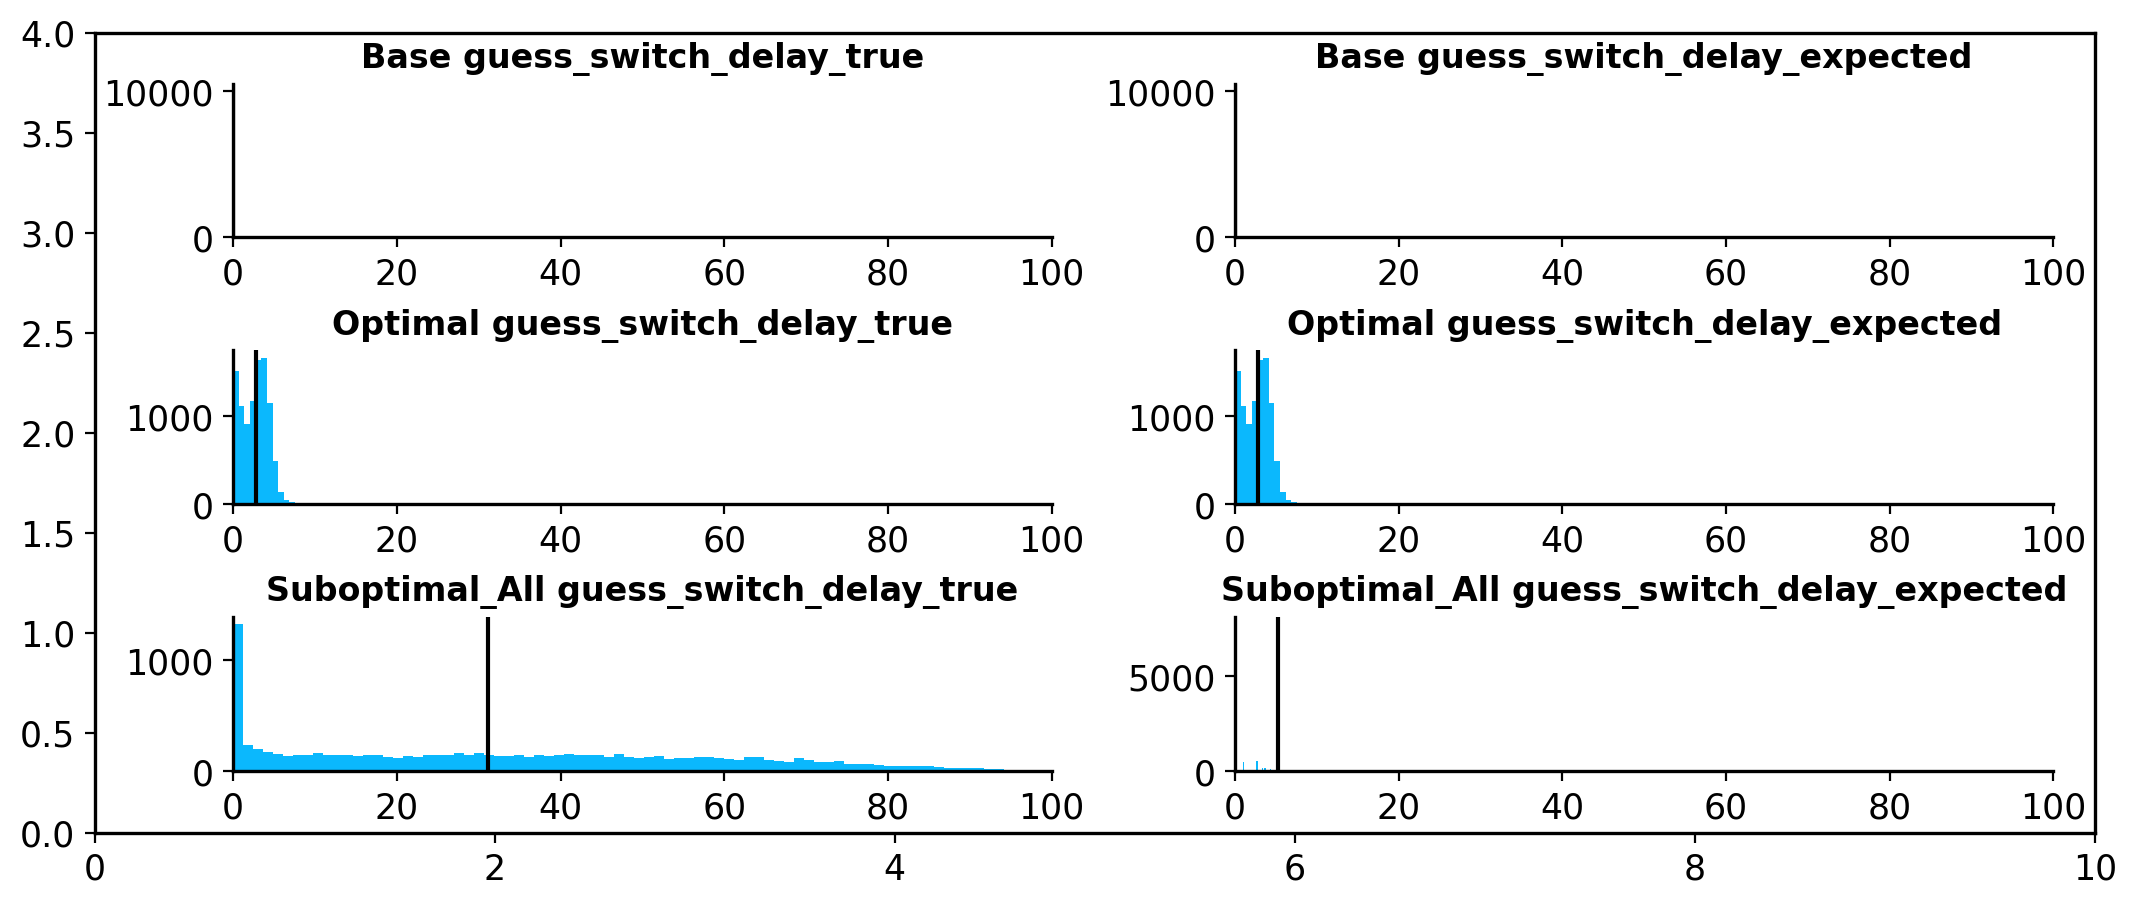

0.0
0.0
70.94533651378723
70.94533651378723
115.3481206631694
14.05583791566874


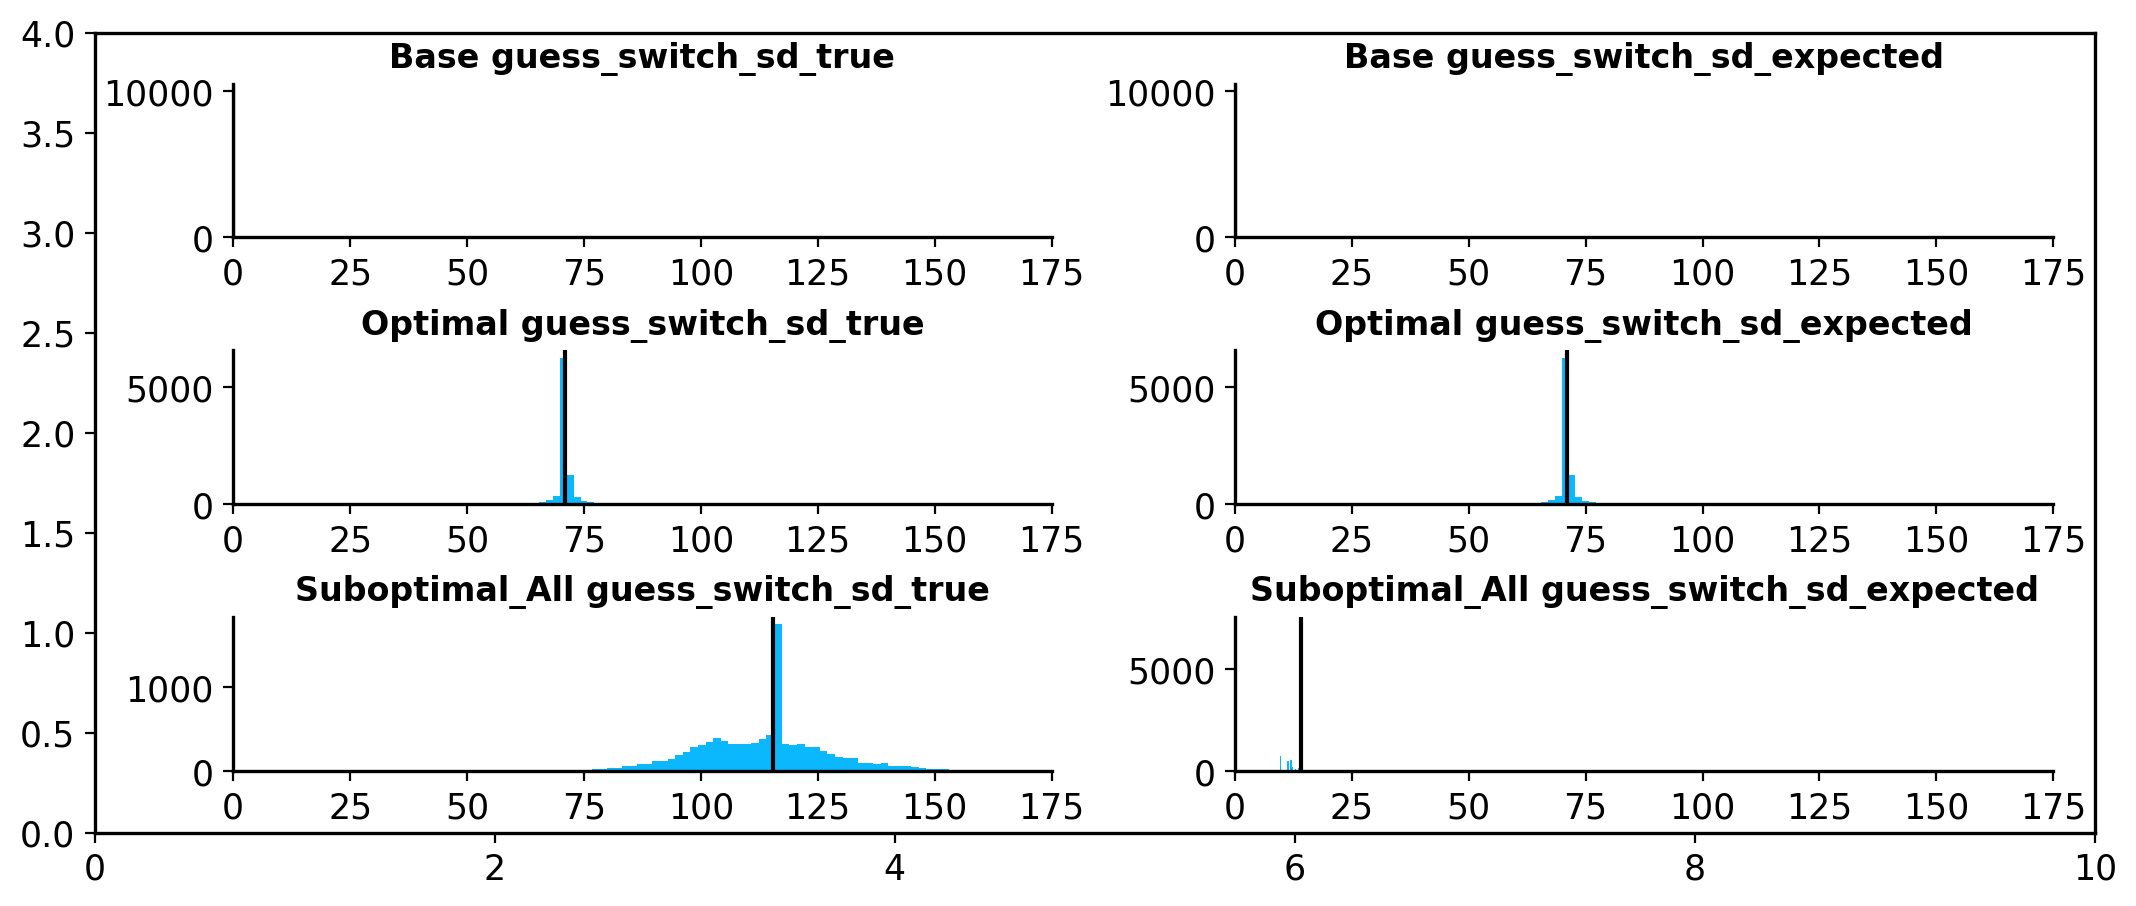

77.60032777744208
77.60032777744208
77.60032777744208
77.60032777744208
77.60032777744208
2.033490731814777


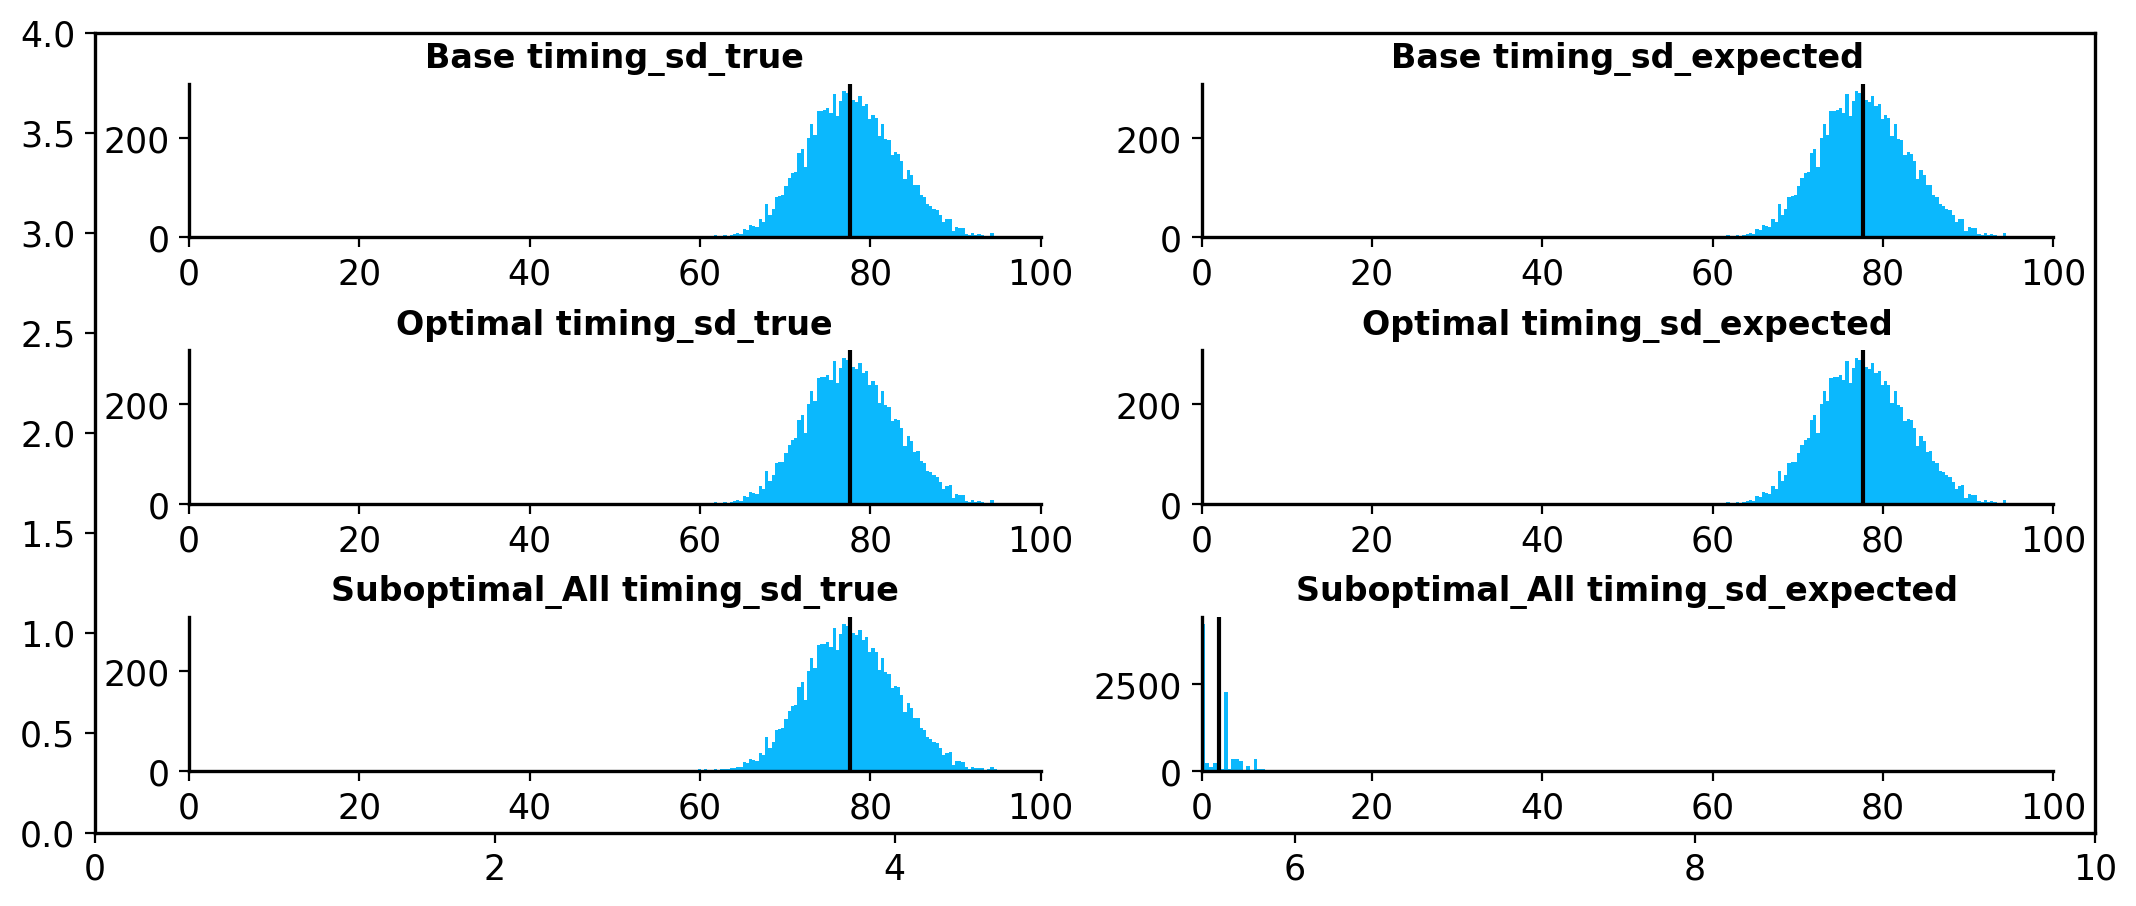

In [13]:
columns = ["guess_switch_delay",
           "guess_switch_sd",
           "timing_sd"]
model_name_to_figure = {model_names[0]:"ab", model_names[1]:"cd", model_names[2]:'ef'}
xlims = {'timing_sd':(0,100),"guess_switch_delay":(0,100), "guess_switch_sd":(0,175)}
for i,col_name in enumerate(columns):
    fig = pf.NewFigure("ab;cd;ef",figsize = (10,4),dpi=200)
    for df_inputs,model_name in zip(model_inputs,model_names):
        col = np.stack(df_inputs[col_name].to_numpy()).squeeze()
        for j in range(2): # Looping through true and expected
            if col.ndim == 1:
                hist = col
                median = np.nanmedian(col)
                sd = np.nanstd(col)
                
            elif col.ndim == 2:
                hist = col[:,j]
                median = np.nanmedian(col[:,j])
                sd = np.nanstd(col[:,j])
            elif col.ndim == 3:
                hist = col[:,j,0]
                median = np.nanmedian(col[:,j,0])
            if j == 0:
                end_title = "_true"
            else:
                end_title = "_expected"
            idx = model_name_to_figure[model_name][j]
            fig.axes[idx].hist(hist,align='mid',bins=100)
            fig.axes[idx].axvline(median)
            print(median)
            fig.axes[idx].set_title(model_name + " " + col_name + end_title, fontsize = 12)
            fig.axes[idx].set_xlim(xlims[col_name])
                # ax.set_xlim(0,16)
                # fig.remove_figure_borders()
    
    plt.show()
        

All Parameters True and Expected

In [4]:
df_inputs.columns

Index(['Model', 'Loss', 'fit_parameters', 'experiment', 'num_blocks',
       'agent_means', 'agent_sds', 'nsteps', 'num_timesteps', 'round_num',
       'expected', 'key', 'use_agent_behavior_lookup', 'reaction_sd',
       'movement_sd', 'timing_sd', 'guess_switch_sd', 'guess_sd',
       'use_true_guess_sd', 'electromechanical_sd', 'guess_sd_from_data',
       'reaction_time', 'movement_time', 'guess_switch_delay',
       'electromechanical_delay', 'guess_delay', 'win_reward',
       'incorrect_cost', 'indecision_cost',
       'prob_selecting_correct_target_reaction',
       'prob_selecting_correct_target_guess'],
      dtype='object')

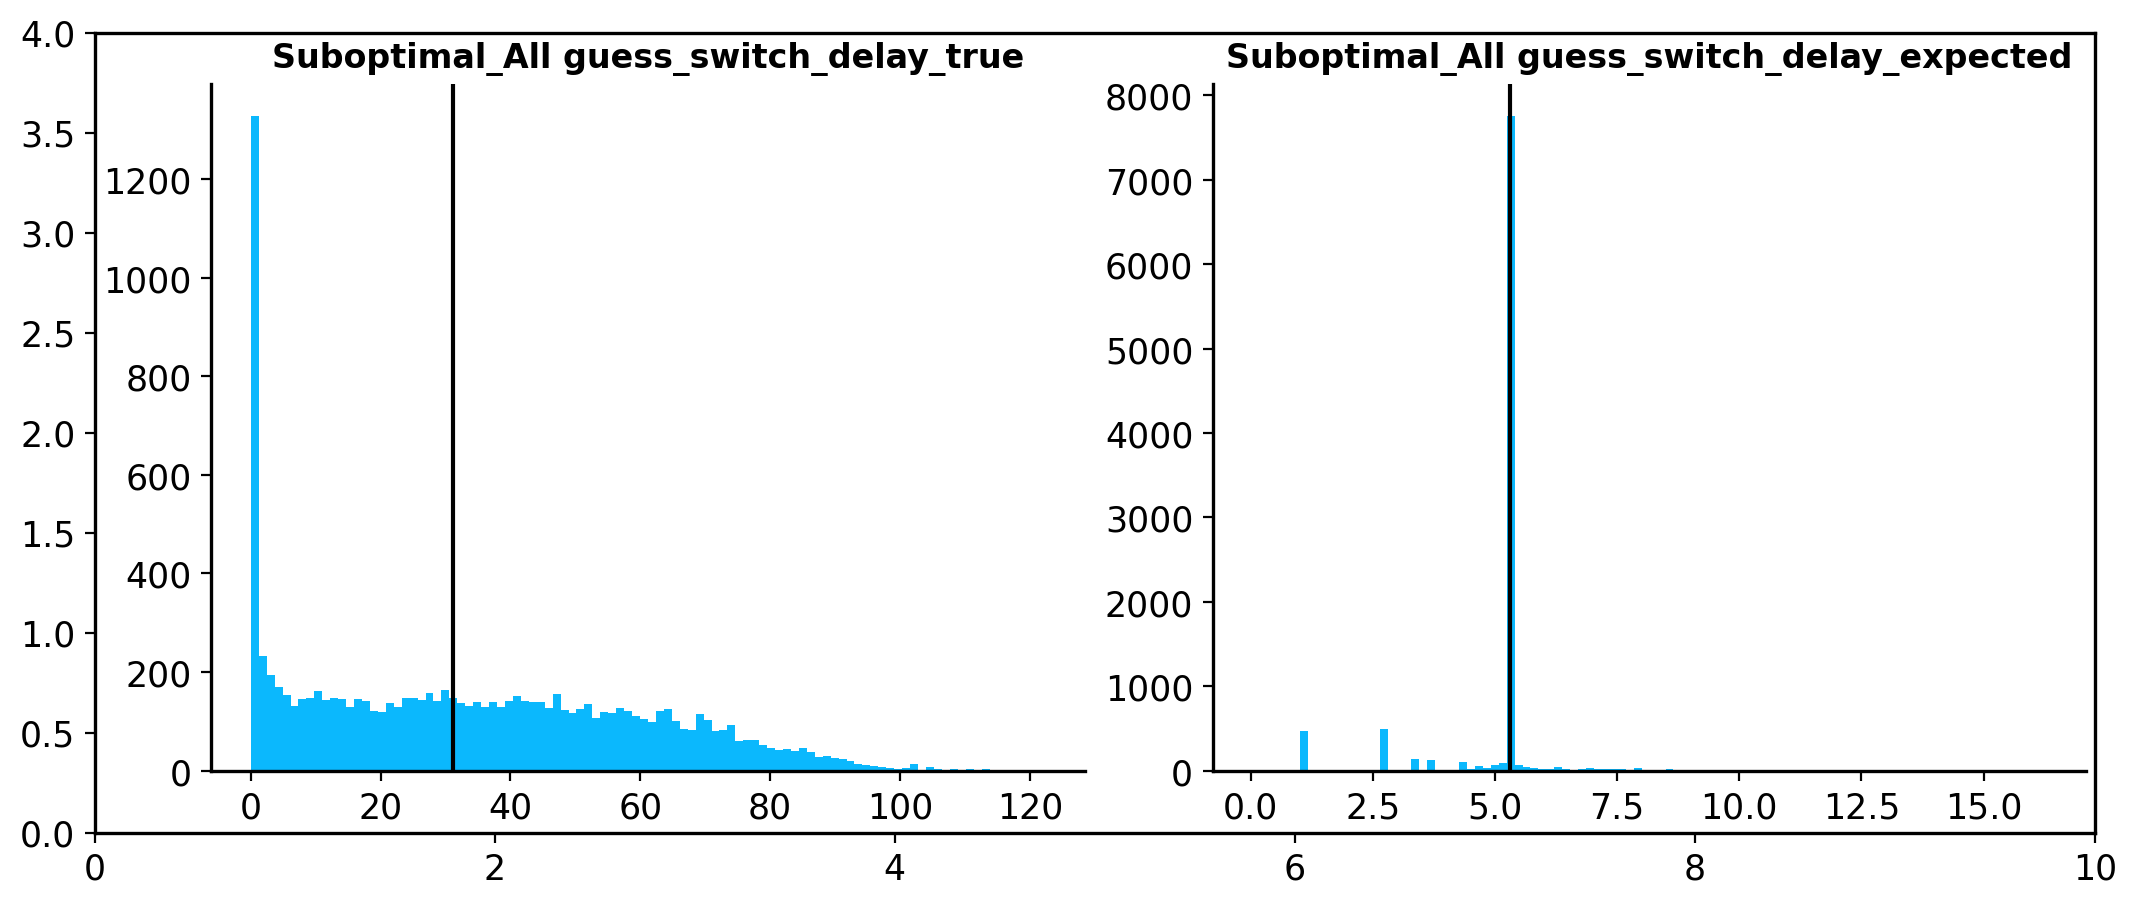

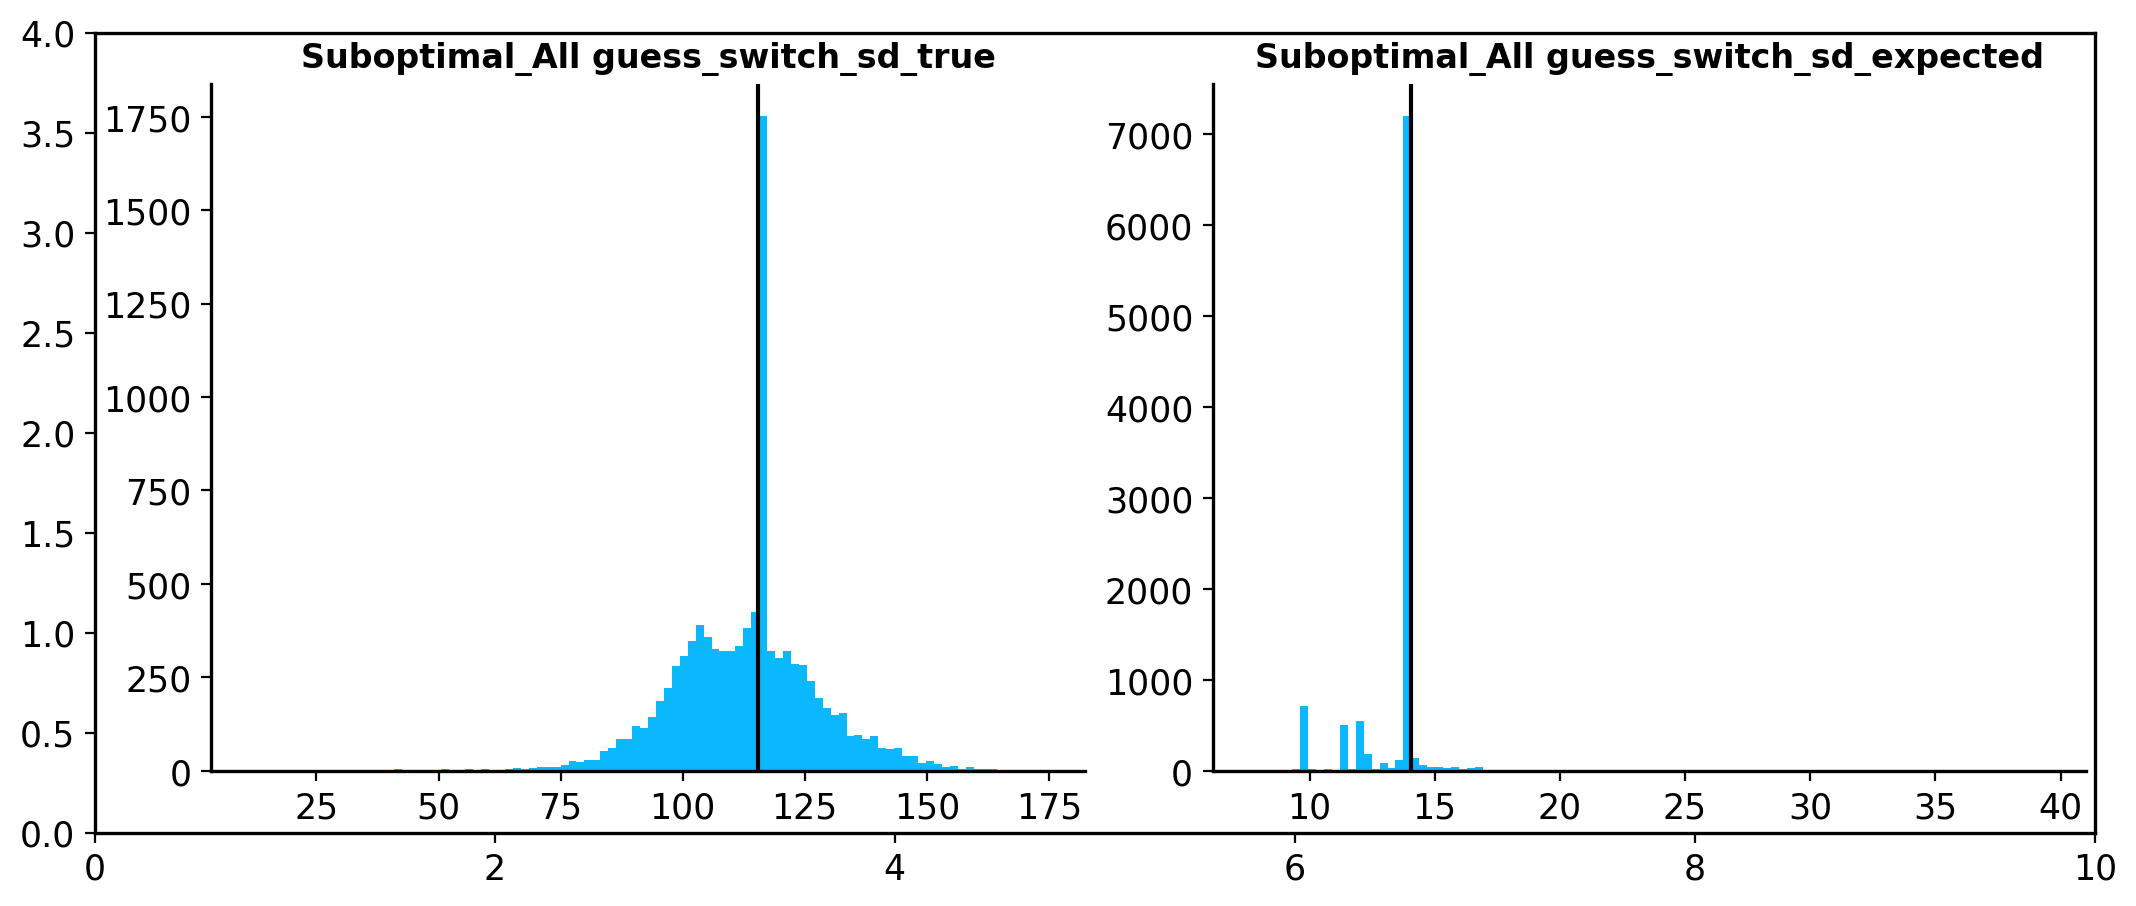

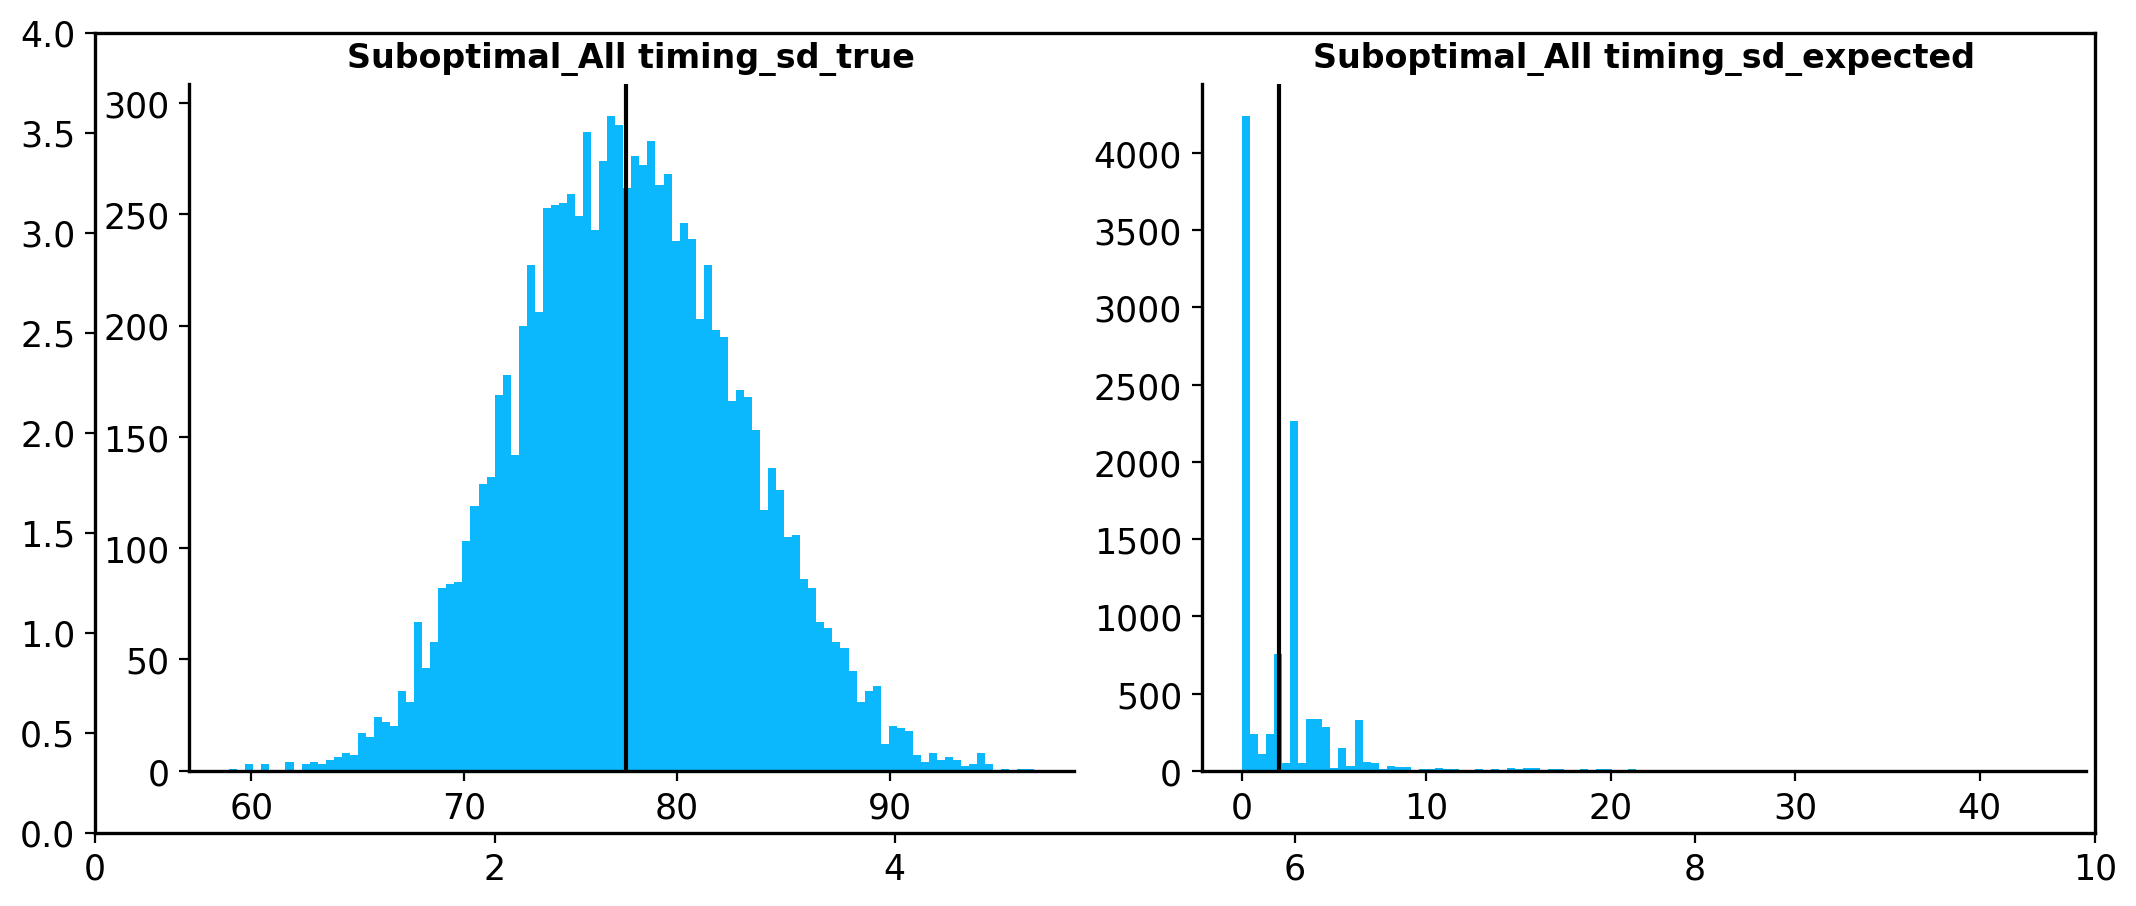

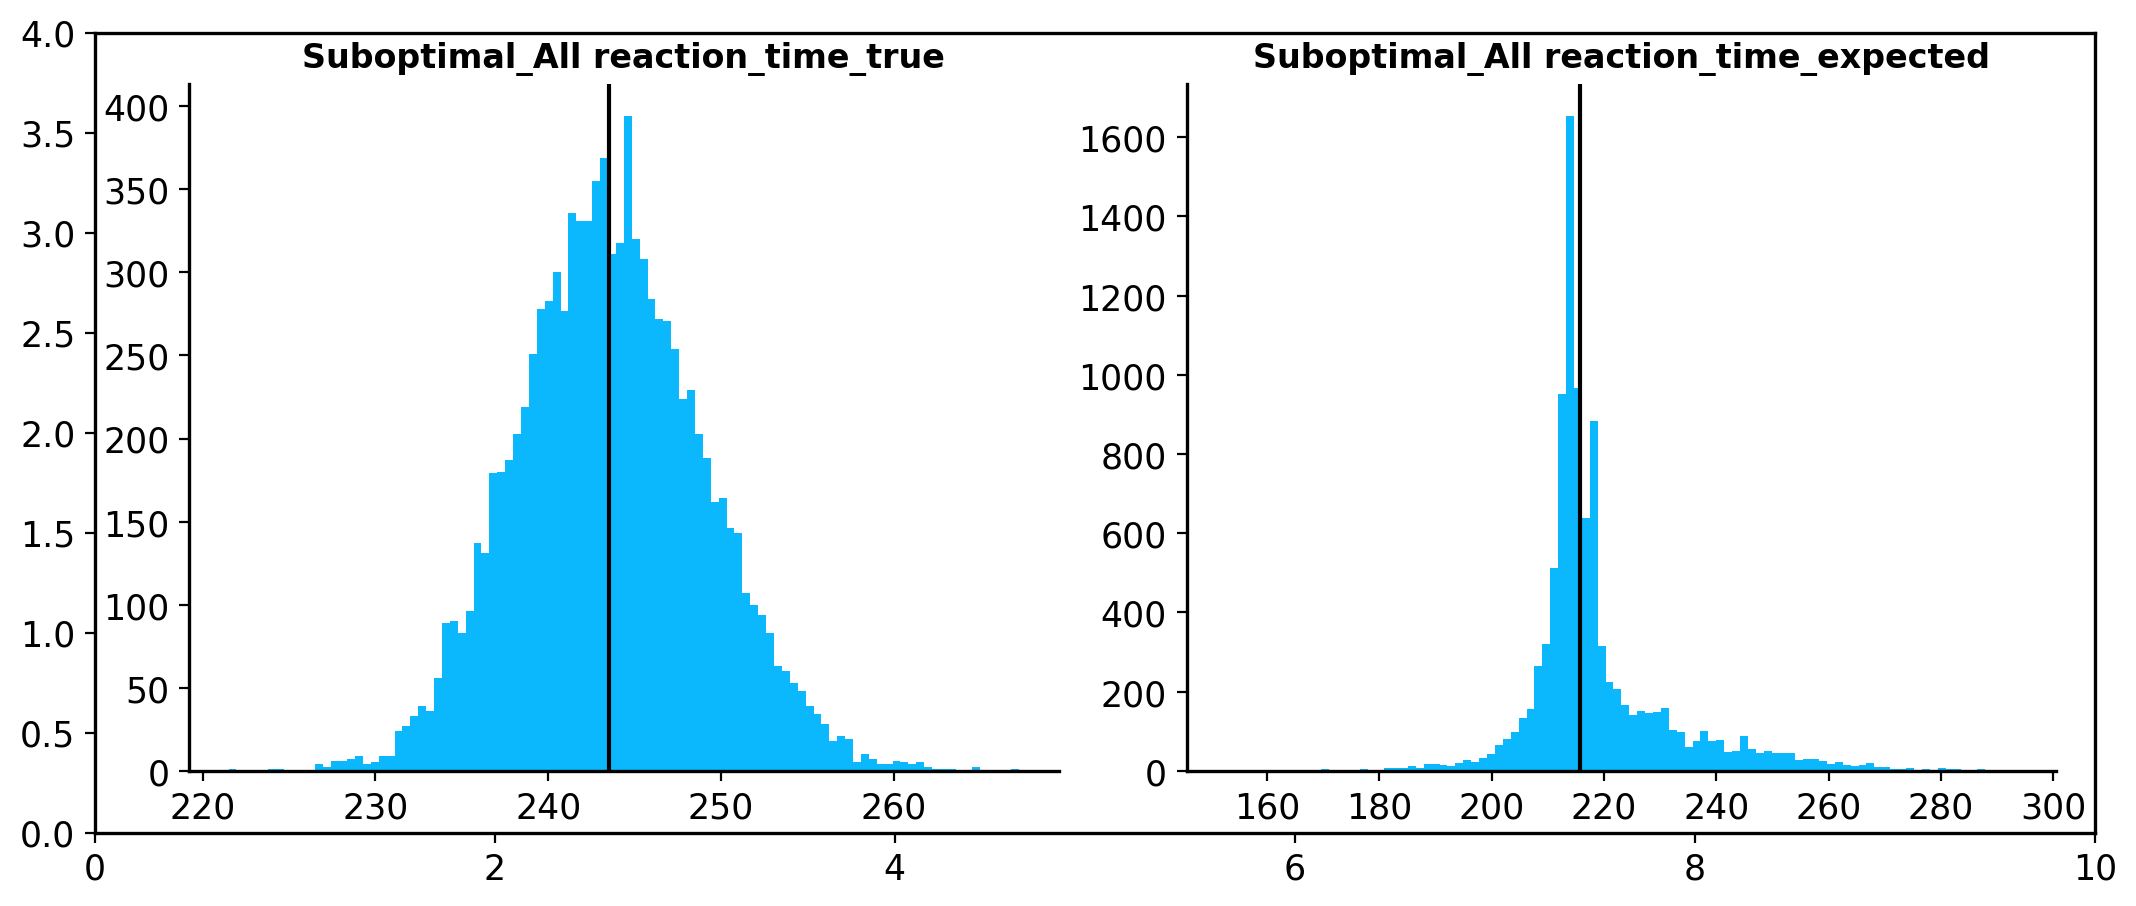

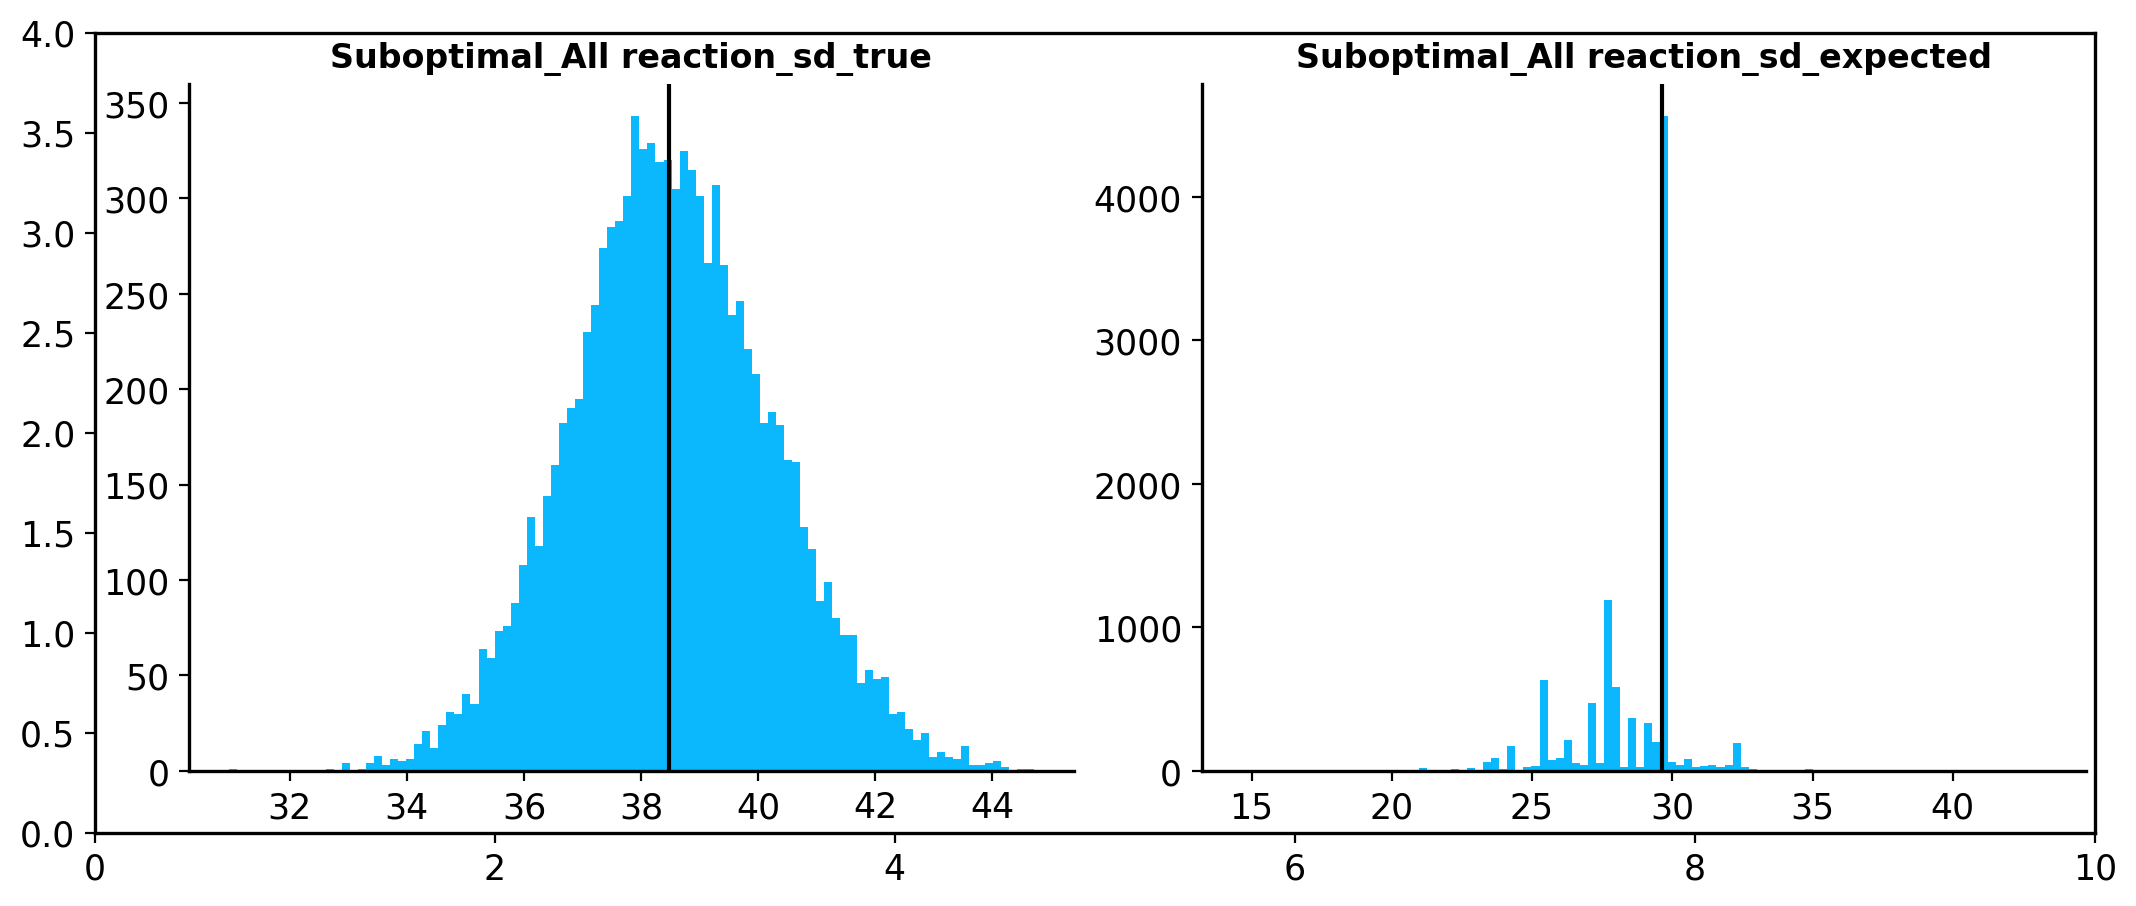

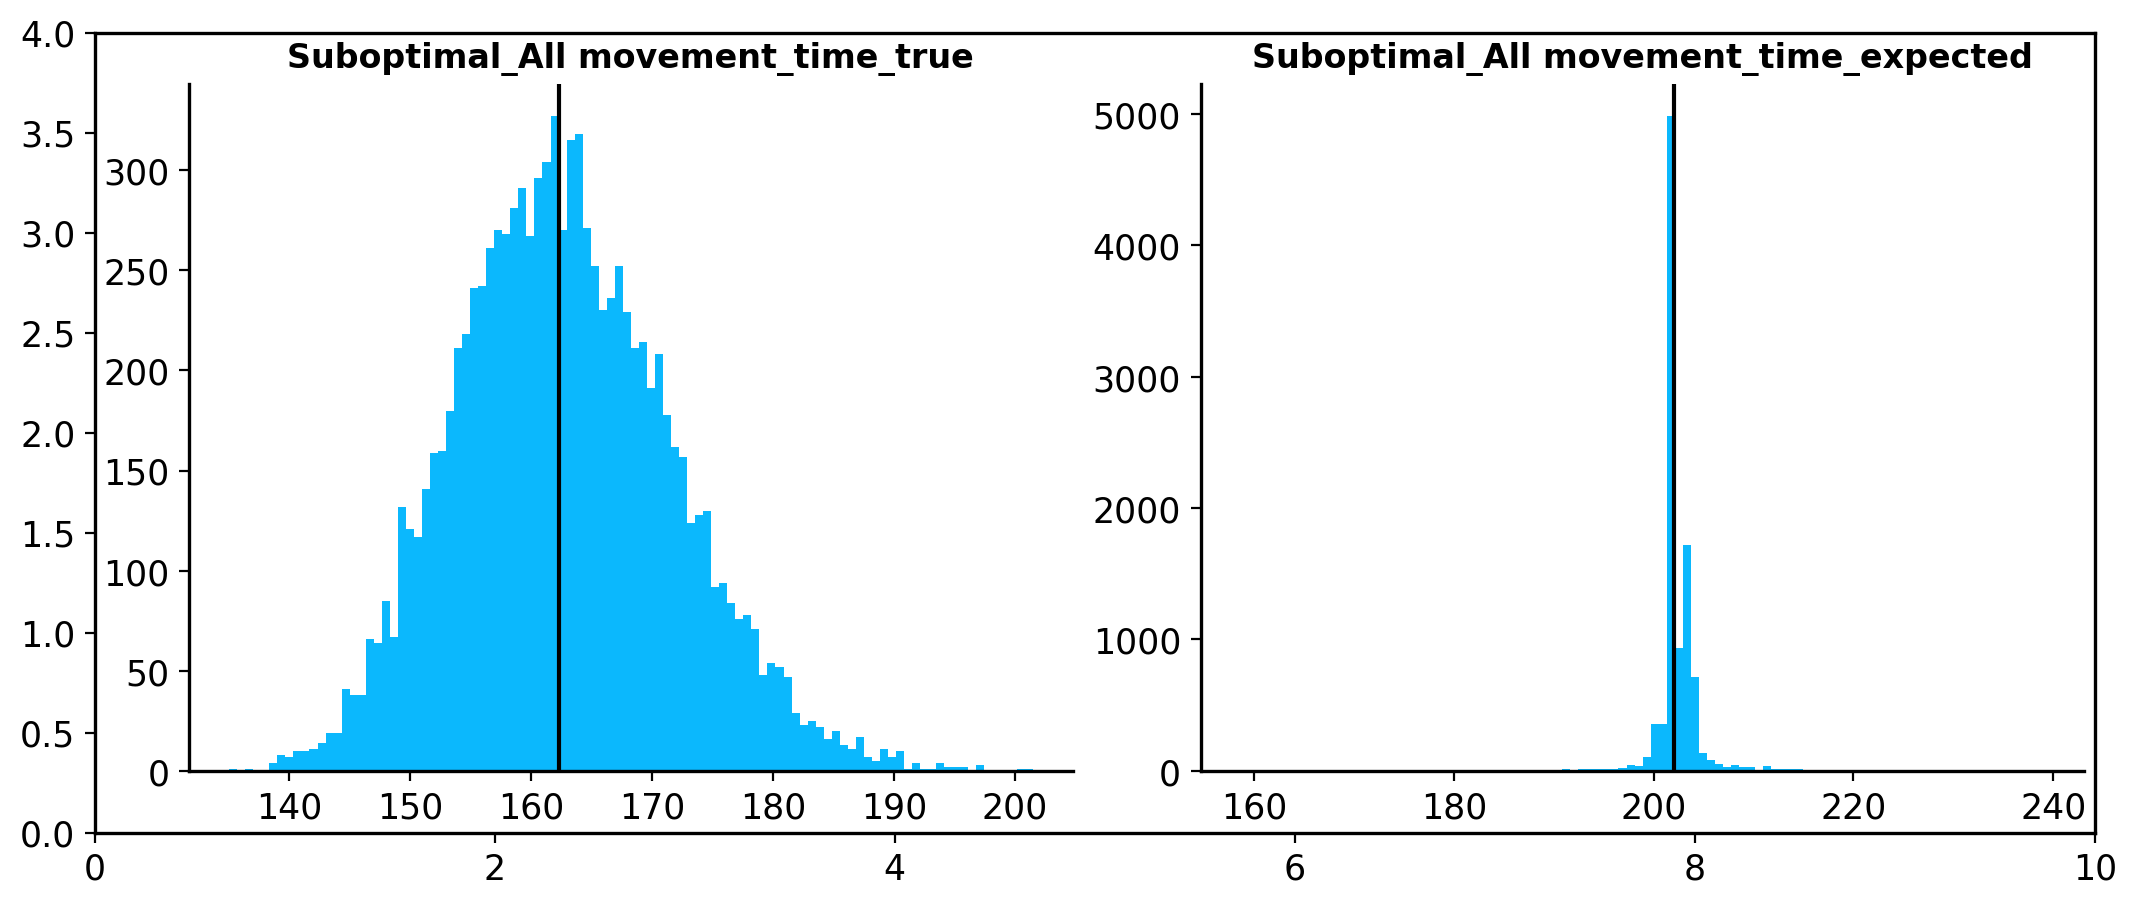

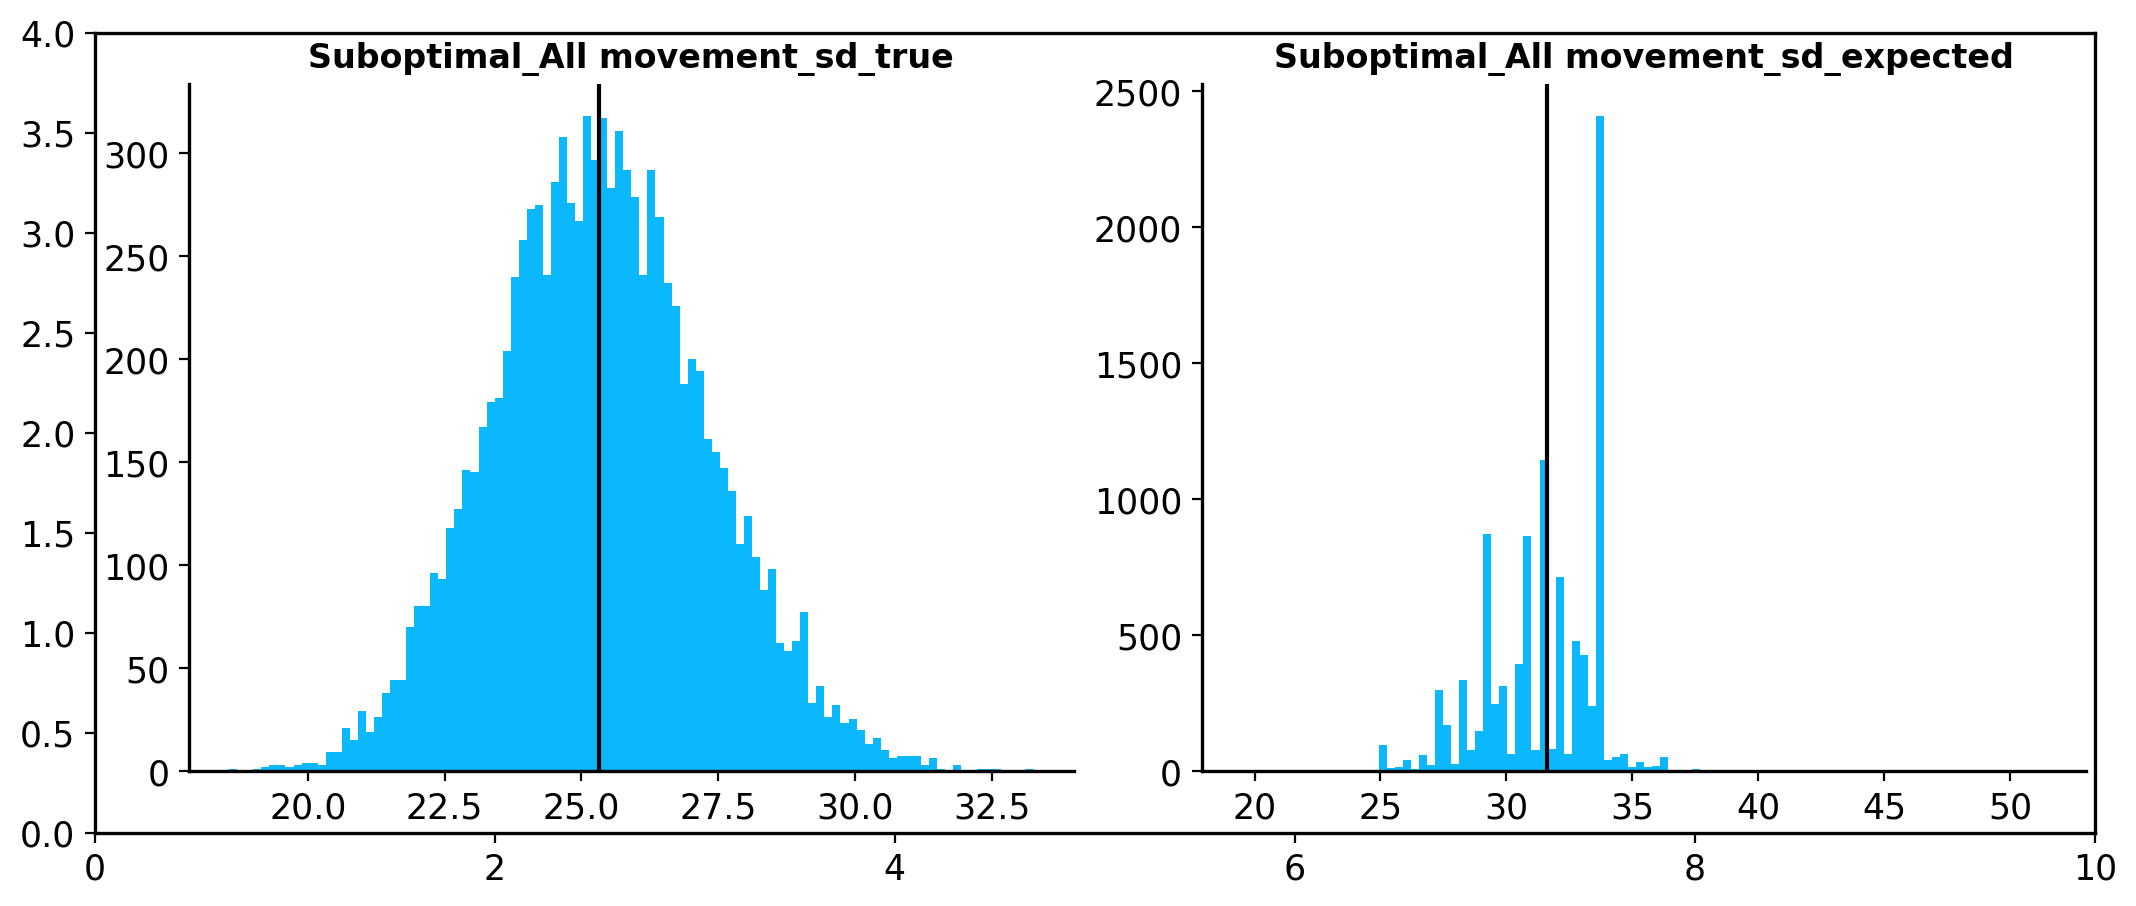

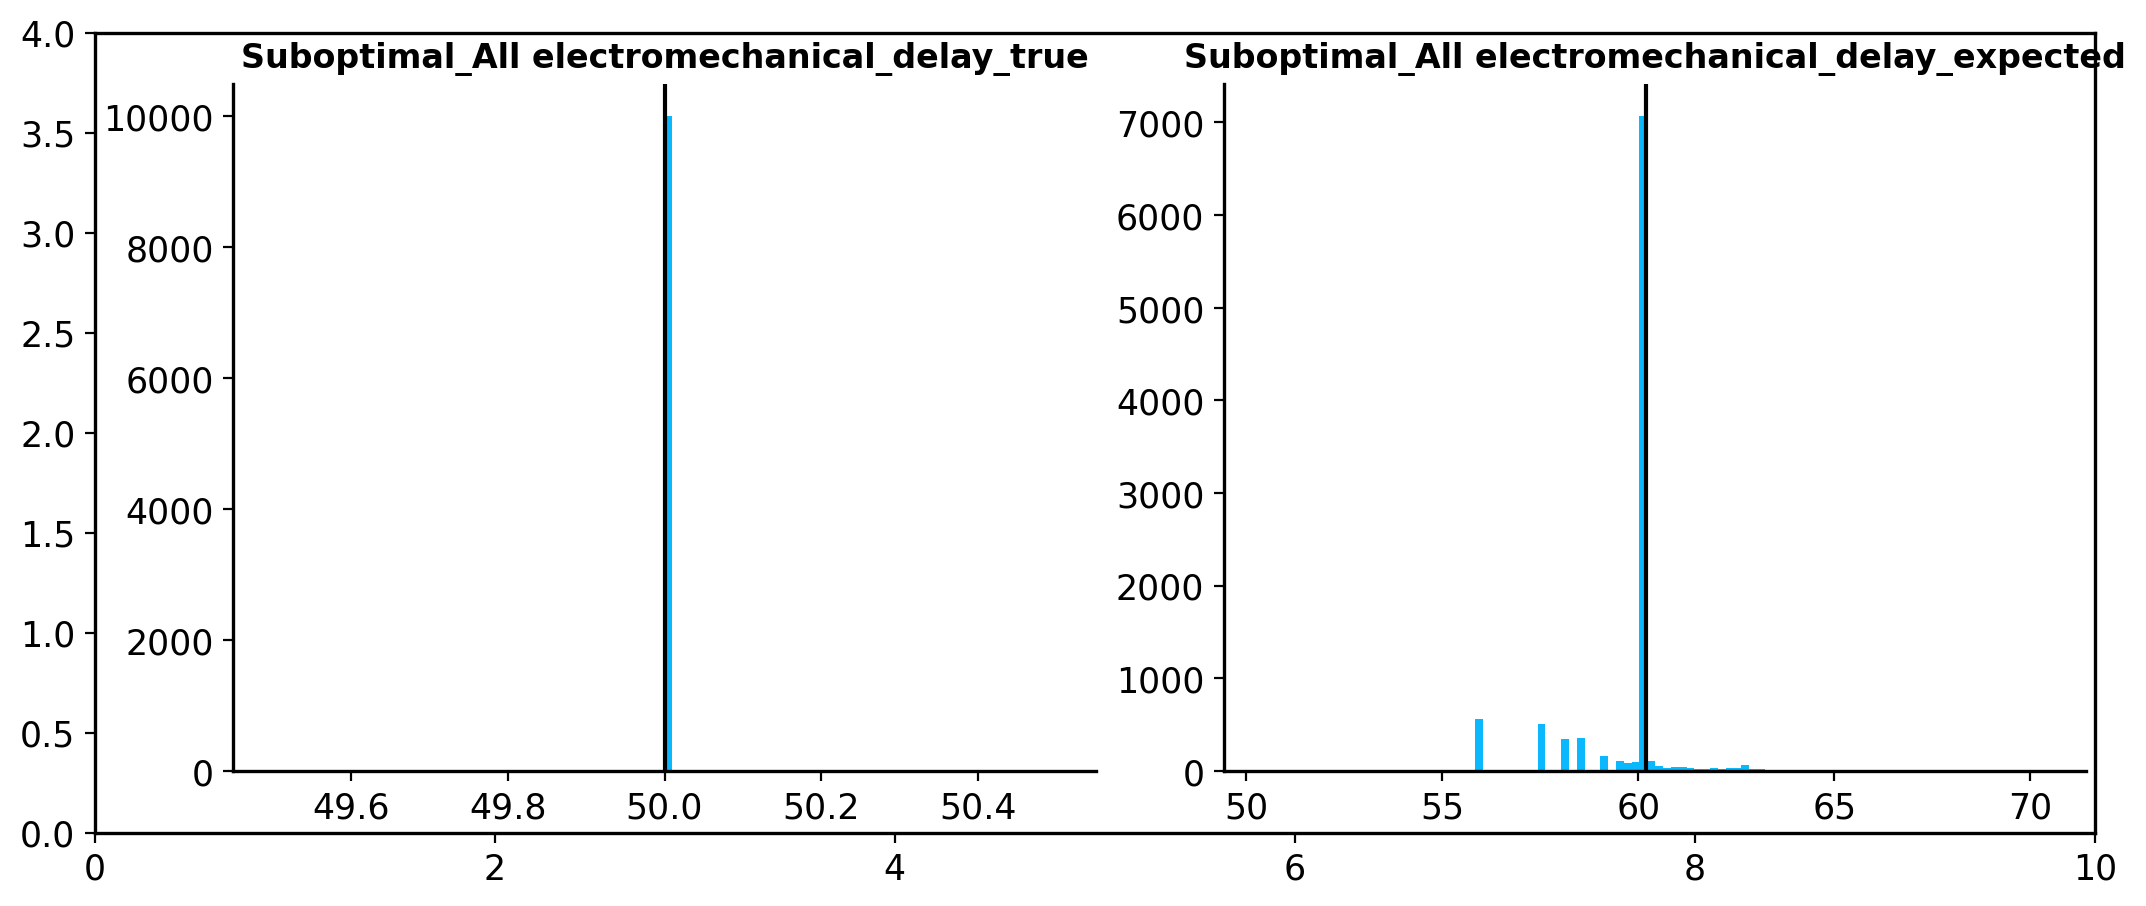

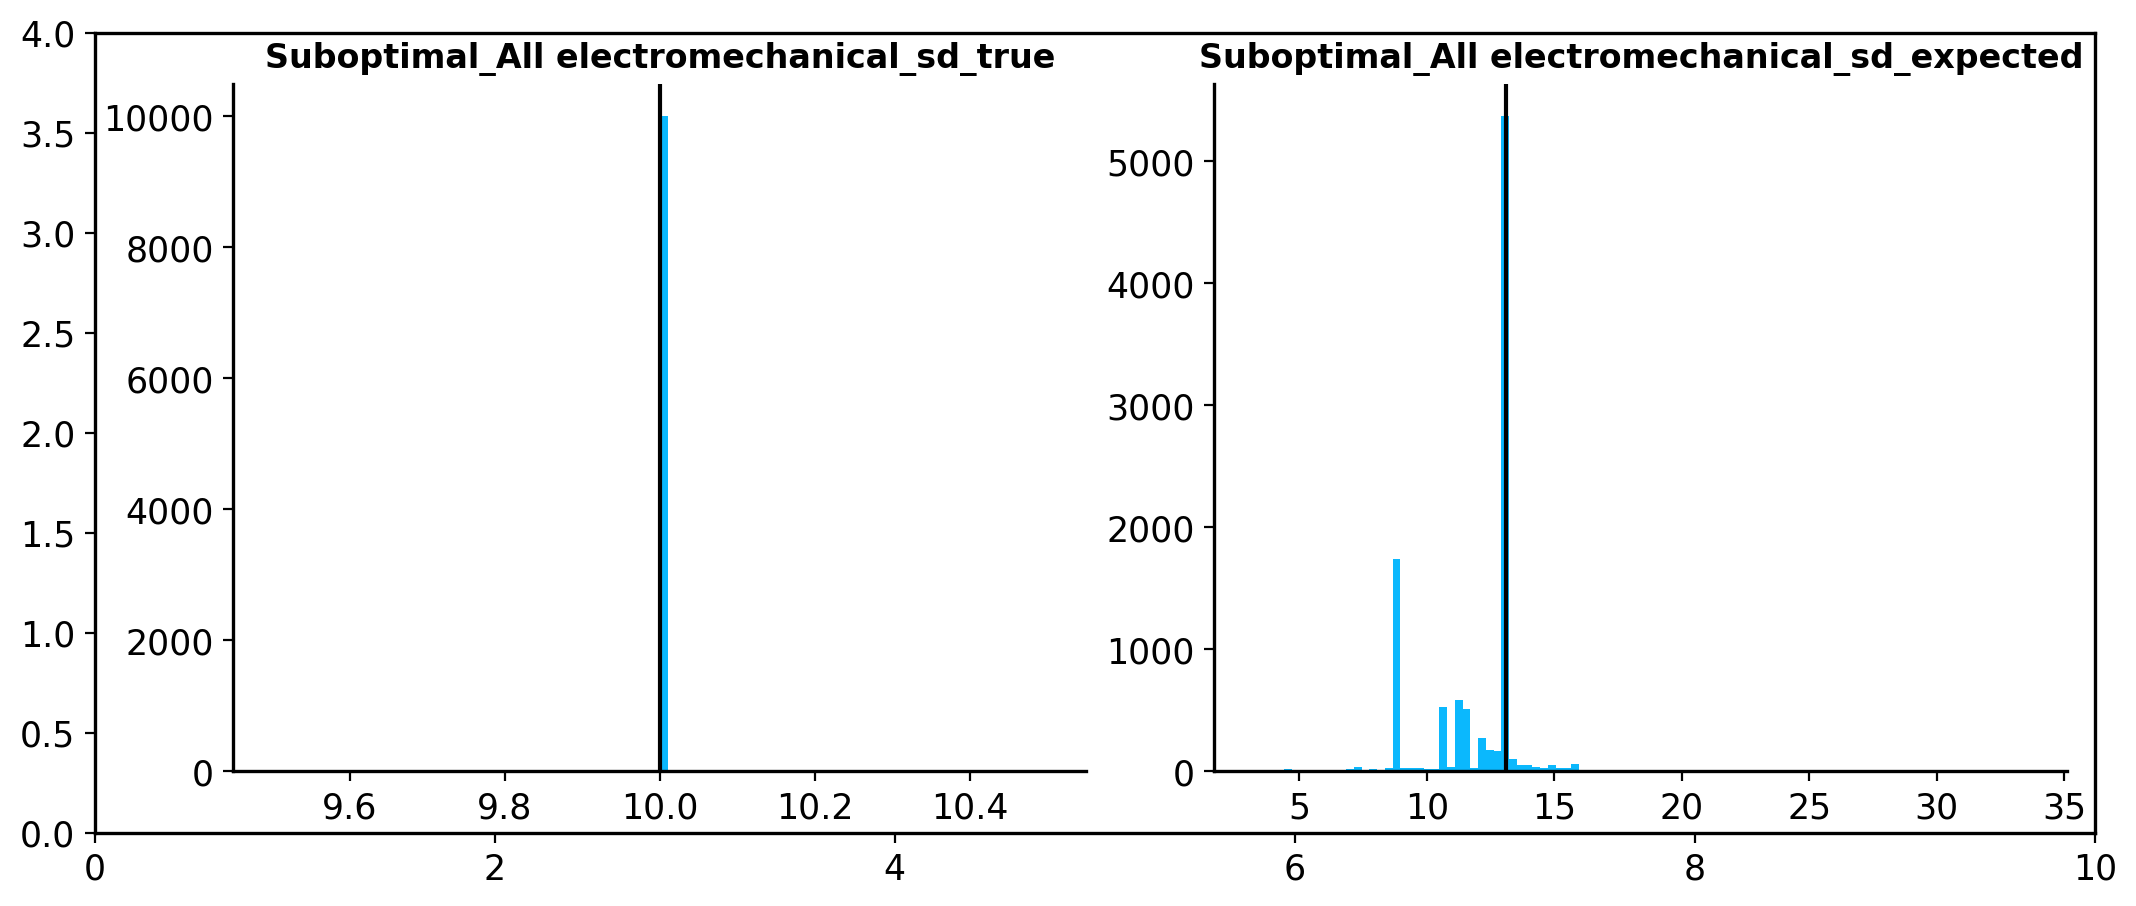

In [5]:
parameter_columns = ["guess_switch_delay",
           "guess_switch_sd",
           "timing_sd",
           "reaction_time",
           "reaction_sd",
           "movement_time",
           "movement_sd",
           "electromechanical_delay",
           "electromechanical_sd",
           ]
model_name_to_figure = {model_names[2]:'ab'}
xlims = {'timing_sd':(0,100),"guess_switch_delay":(0,100), "guess_switch_sd":(0,175)}
for i,col_name in enumerate(parameter_columns):
    fig = pf.NewFigure("ab",figsize = (10,4),dpi=200)
    for df_inputs,model_name in zip(model_inputs[2:],model_names[2:]):
        col = np.stack(df_inputs[col_name].to_numpy()).squeeze()
        for j in range(2): # Looping through true and expected
            if col.ndim == 1:
                hist = col
                median = np.nanmedian(col)
                sd = np.nanstd(col)
                
            elif col.ndim == 2:
                hist = col[:,j]
                median = np.nanmedian(col[:,j])
                sd = np.nanstd(col[:,j])
            elif col.ndim == 3:
                hist = col[:,j,0]
                median = np.nanmedian(col[:,j,0])
            if j == 0:
                end_title = "_true"
            else:
                end_title = "_expected"
            idx = model_name_to_figure[model_name][j]
            fig.axes[idx].hist(hist,align='mid',bins=100)
            fig.axes[idx].axvline(median)
            fig.axes[idx].set_title(model_name + " " + col_name + end_title, fontsize = 12)
            # fig.axes[idx].set_xlim(xlims[col_name])
                # ax.set_xlim(0,16)
                # fig.remove_figure_borders()
    
    plt.show()

(2,)
(2,)
(2, 6)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)


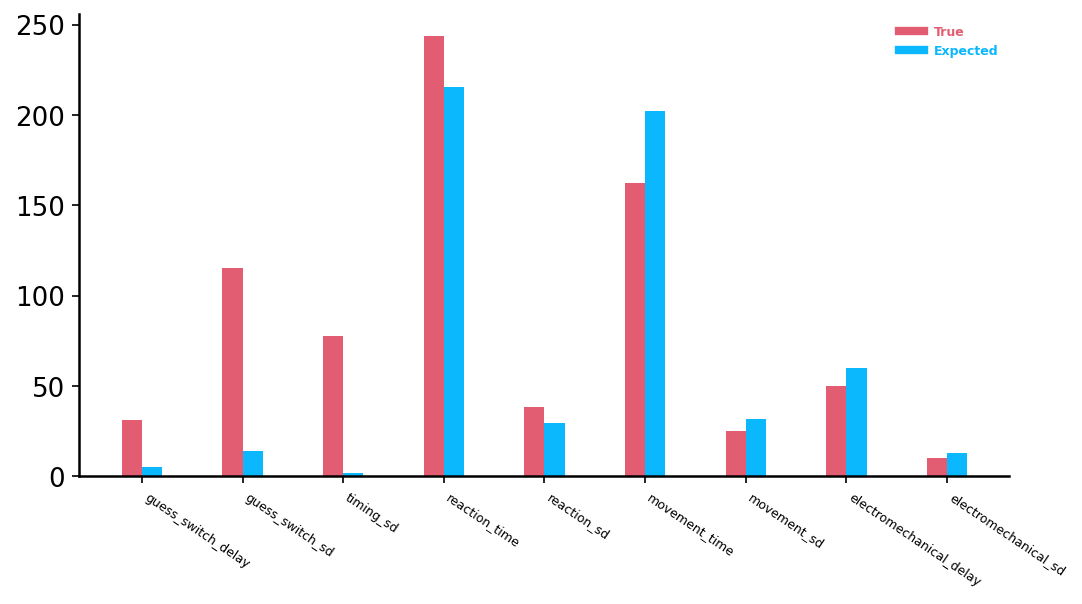

In [6]:
fig,ax = plt.subplots(dpi=150,figsize=(8,4))
barwidth = 0.2
xlocs = np.arange(0, len(parameter_columns))
for i,col_name in enumerate(parameter_columns):
    col = np.stack(df_inputs[col_name].to_numpy()).squeeze()
    col = np.nanmedian(col,axis=0)
    print(col.shape)
    if col.ndim>1:
        col = col[:,0]
    ax.bar([xlocs[i]-barwidth/2,xlocs[i]+barwidth/2], col, width=barwidth, color=[wheel.rak_red, wheel.rak_blue])
ax.set_xticks(xlocs, labels=parameter_columns, fontsize=6,rotation=-34, ha = 'left')
dv.legend(ax, labels=["True", "Expected"], colors=[wheel.rak_red,wheel.rak_blue])
plt.show()

In [7]:
bootstrapped_path = constants.MODELS_PATH / f"bootstrapped_models"
bootstrapped_model_results = []
bootstrapped_model_inputs = []
for model in model_names[2:]:
    results_path = list(bootstrapped_path.glob(f"{EXPERIMENT}_{model.lower()}_bootstrapped_results*"))[-1]
    inputs_path = list(bootstrapped_path.glob(f"{EXPERIMENT}_{model.lower()}_bootstrapped_inputs*"))[-1]
    temp_results = pd.read_pickle(bootstrapped_path / results_path)
    try:
        temp_results['num_parameters'] = 7 + temp_results["fit_parameters"].apply(len) # Add on number of parameters
    except KeyError:
        temp_results['num_parameters'] = 7
        
    # temp_results['bic'] = 30*np.log(temp_results['Loss']/30) + temp_results['num_parameters']*np.log(30)
    temp_results['bic'] = temp_results['num_parameters']*np.log(30) + 2*np.log(temp_results['Loss'])
    temp_results['aic'] = 2*temp_results['num_parameters'] + 2*np.log(temp_results['Loss'])
    temp_inputs = pd.read_pickle(bootstrapped_path / inputs_path)
    bootstrapped_model_results.append(temp_results)
    bootstrapped_model_inputs.append(temp_inputs)
    
columns = ["guess_switch_delay",
           "guess_switch_sd",]
model_name_to_figure = {model_names[1]:"ab", model_names[2]:"cd"}
xlims = {'timing_sd':(0,100),"guess_switch_delay":(0,100), "guess_switch_sd":(0,175)}
optimal_param_array = []
suboptimal_param_array = []
for i,col_name in enumerate(columns):
    col1 = np.stack(bootstrapped_model_inputs[0][col_name].to_numpy()).squeeze()
    col2 = np.stack(bootstrapped_model_inputs[1][col_name].to_numpy()).squeeze()
    try:
        optimal_param_array.append(col1[:,0,0]) # True value
        optimal_param_array.append(col1[:,1,0]) # Expected value
    except:
        optimal_param_array.append(col1[:,0])
        optimal_param_array.append(col1[:,1])
        
    try:
        suboptimal_param_array.append(col2[:,0,0]) # True value
        suboptimal_param_array.append(col2[:,1,0]) # Expected value
    except:
        suboptimal_param_array.append(col2[:,0])
        suboptimal_param_array.append(col2[:,1])
            
labels = ["guess_switch_delay_true","guess_switch_delay_expected",
          "guess_switch_sd_true","guess_switch_sd_expected"]
dv.Pair_Plot(parameter_array=np.array(optimal_param_array).T,
             labels=labels, remove_heavy_outliers=False, labelsize=3.5)
plt.show()

IndexError: list index out of range

Pair Plot (warmstarts)

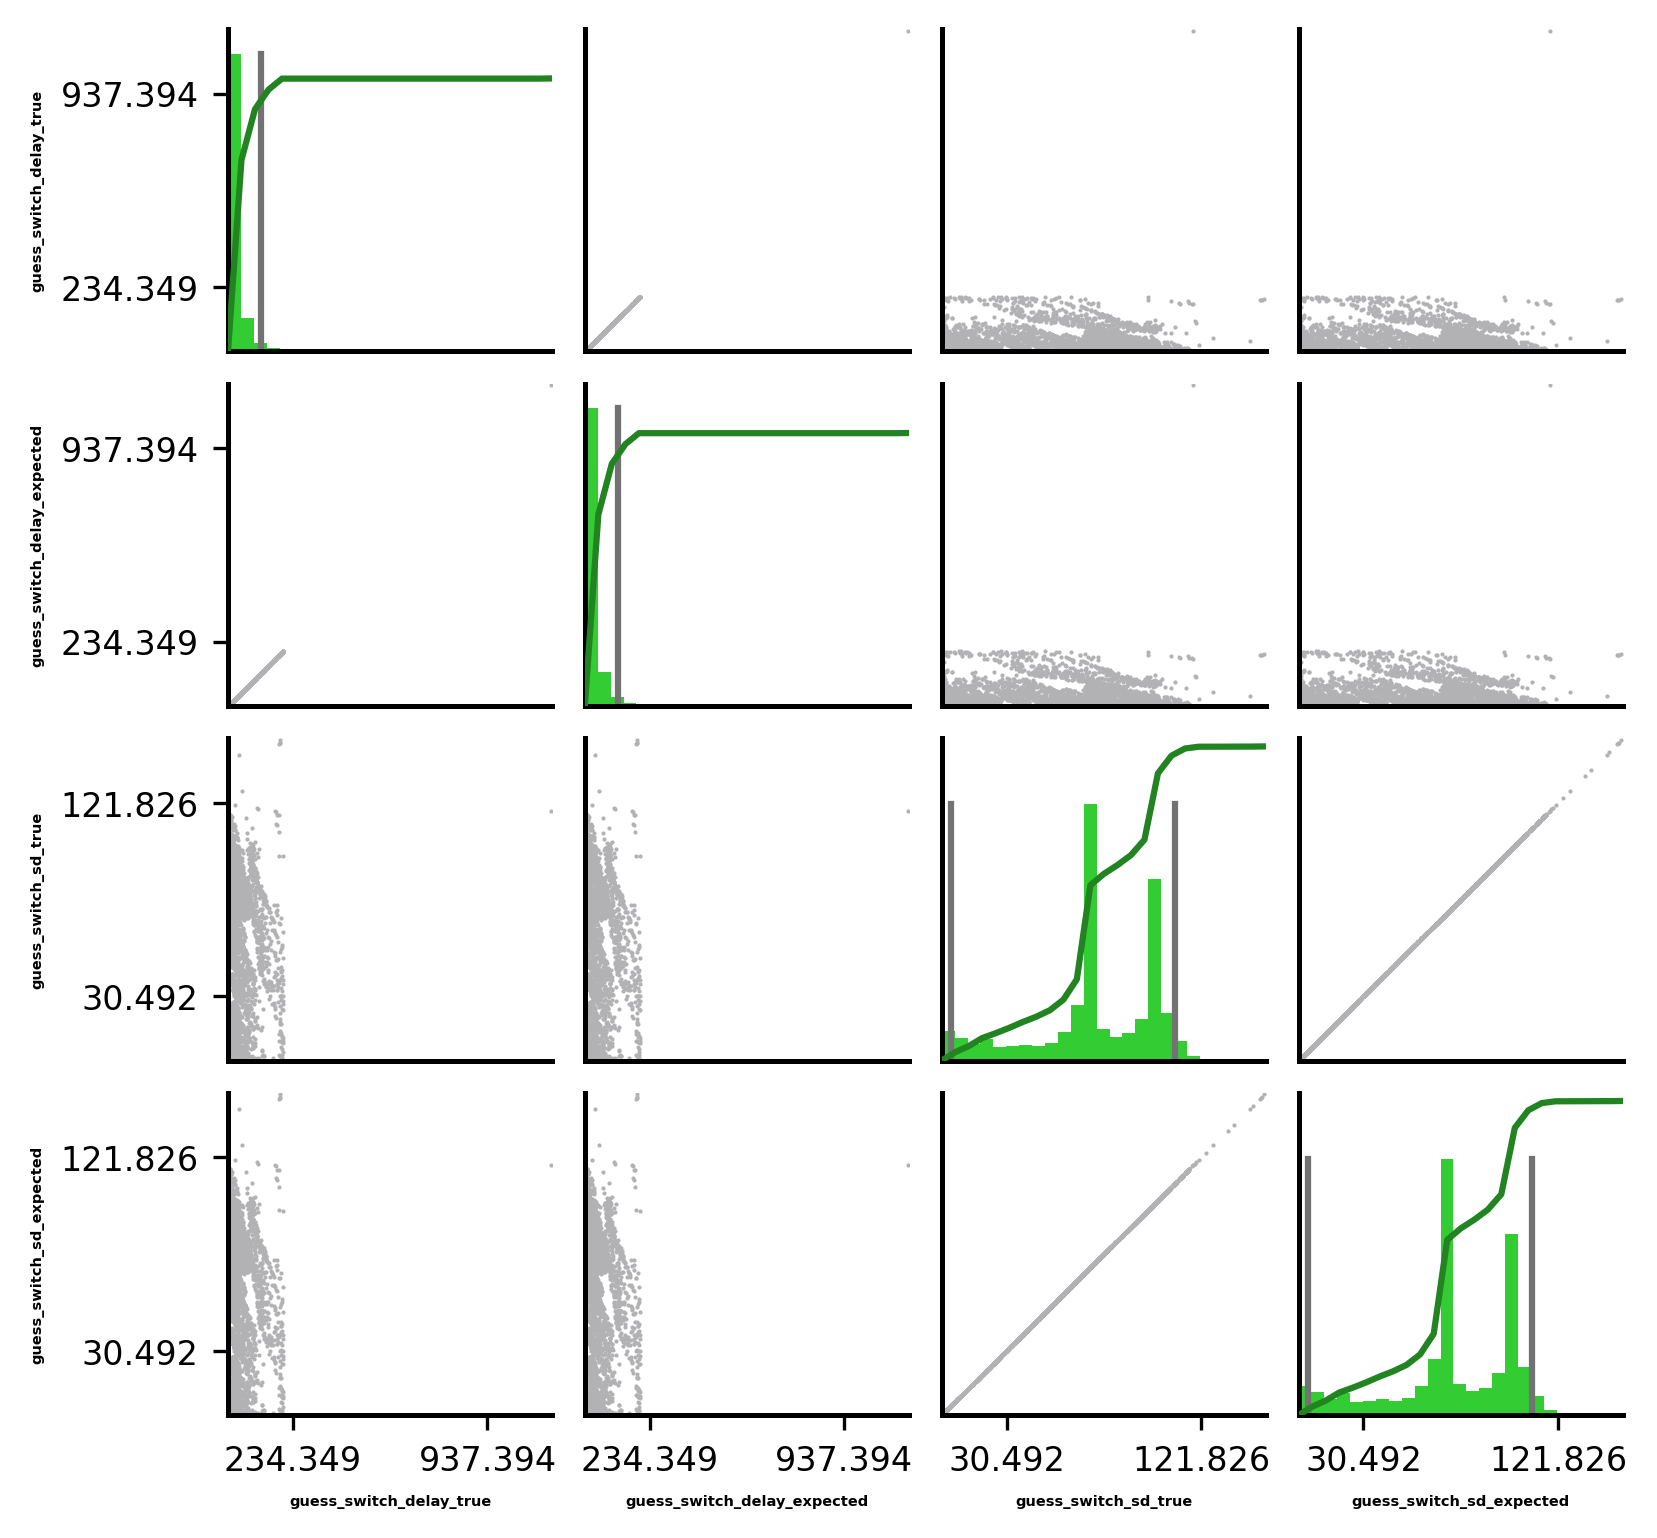

In [ ]:
warmstart_path = constants.MODELS_PATH / f"warmstart_models"
warmstart_model_results = []
warmstart_model_inputs = []
for model in model_names[1:]:
    results_path = list(warmstart_path.glob(f"{EXPERIMENT}_{model.lower()}_warmstart_results*"))[-1]
    inputs_path = list(warmstart_path.glob(f"{EXPERIMENT}_{model.lower()}_warmstart_inputs*"))[-1]
    temp_results = pd.read_pickle(warmstart_path / results_path)
    try:
        temp_results['num_parameters'] = 7 + temp_results["fit_parameters"].apply(len) # Add on number of parameters
    except KeyError:
        temp_results['num_parameters'] = 7
        
    # temp_results['bic'] = 30*np.log(temp_results['Loss']/30) + temp_results['num_parameters']*np.log(30)
    temp_results['bic'] = temp_results['num_parameters']*np.log(30) + 2*np.log(temp_results['Loss'])
    temp_results['aic'] = 2*temp_results['num_parameters'] + 2*np.log(temp_results['Loss'])
    temp_inputs = pd.read_pickle(warmstart_path / inputs_path)
    warmstart_model_results.append(temp_results)
    warmstart_model_inputs.append(temp_inputs)
columns = ["guess_switch_delay",
           "guess_switch_sd",]
model_name_to_figure = {model_names[1]:"ab", model_names[2]:"cd"}
xlims = {'timing_sd':(0,100),"guess_switch_delay":(0,100), "guess_switch_sd":(0,175)}
optimal_param_array = []
suboptimal_param_array = []
for i,col_name in enumerate(columns):
    col1 = np.stack(warmstart_model_inputs[0][col_name].to_numpy()).squeeze()
    col2 = np.stack(warmstart_model_inputs[1][col_name].to_numpy()).squeeze()
    try:
        optimal_param_array.append(col1[:,0,0]) # True value
        optimal_param_array.append(col1[:,1,0]) # Expected value
    except:
        optimal_param_array.append(col1[:,0])
        optimal_param_array.append(col1[:,1])
        
    try:
        suboptimal_param_array.append(col2[:,0,0]) # True value
        suboptimal_param_array.append(col2[:,1,0]) # Expected value
    except:
        suboptimal_param_array.append(col2[:,0])
        suboptimal_param_array.append(col2[:,1])
            
labels = ["guess_switch_delay_true","guess_switch_delay_expected",
          "guess_switch_sd_true","guess_switch_sd_expected"]
dv.Pair_Plot(parameter_array=np.array(optimal_param_array).T,
             labels=labels, remove_heavy_outliers=False, labelsize=3.5)
plt.show()

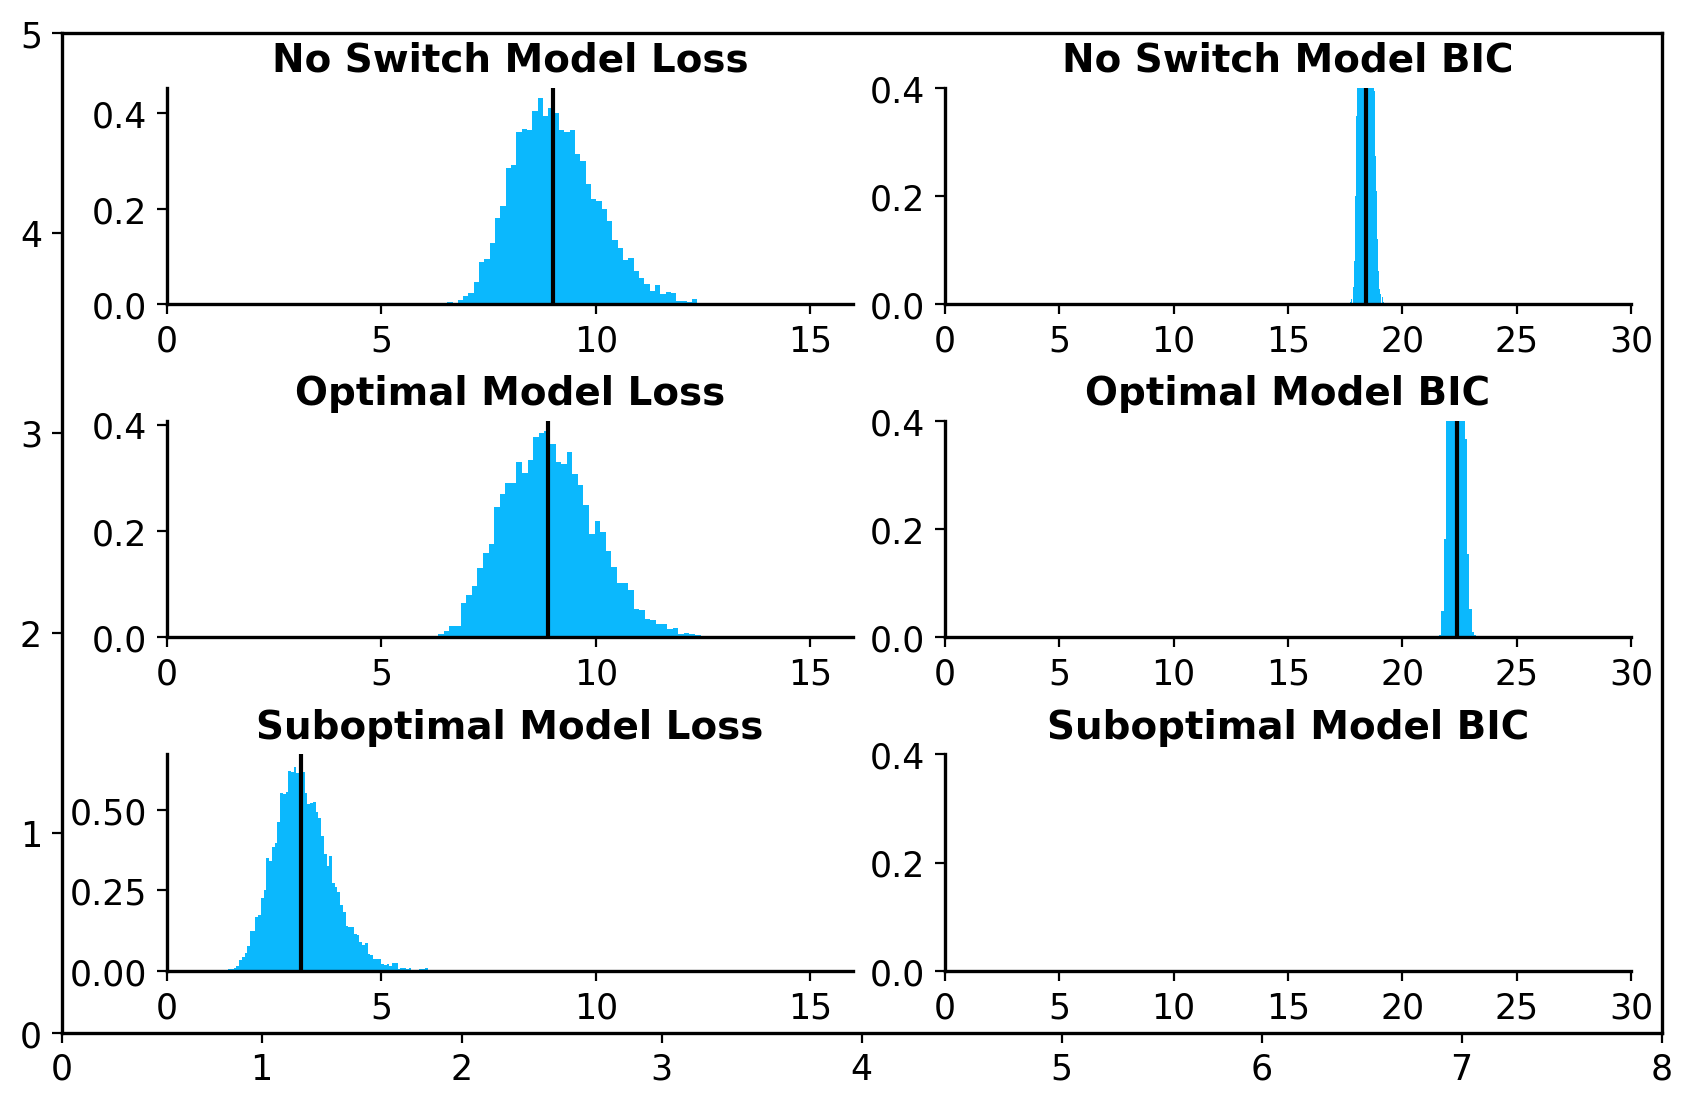

In [ ]:
columns = ["Loss","aic",]
loss = []
bic = []
for i in range(len(model_results)):
    loss.append(np.stack(model_results[i]["Loss"].to_numpy()))
    bic.append(np.stack(model_results[i]["aic"].to_numpy()))

loss_titles = ["No Switch Model Loss", "Optimal Model Loss", "Suboptimal Model Loss"]
bic_titles  = ["No Switch Model BIC", "Optimal Model BIC", "Suboptimal Model BIC"]
fig = pf.NewFigure("ab;cd;ef",figsize = (8,5),dpi=200)
ax1,ax2,ax3,ax4,ax5,ax6 = fig.axes.values()
for i,ax in enumerate(fig.axes.values()):
    if i%2==0:
        loss[i//2] = np.where(loss[i//2]>40,np.nan,loss[i//2])
        ax.hist(loss[i//2],align='mid',bins=100,density=True)
        ax.axvline(np.nanmedian(loss[i//2]))
        ax.set_title(loss_titles[i//2], fontsize=14)
        ax.set_xlim(0,16)
    else:
        # bic[i//2] = np.where(bic[i//2]>40,np.nan,bic[i//2])
        ax.hist(bic[i//2],align='mid',bins=100,density=True)
        ax.axvline(np.median(bic[i//2]))
        ax.set_title(bic_titles[i//2], fontsize=14)
        ax.set_xlim(0,30)
        ax.set_ylim(0,0.4)
        # fig.remove_figure_borders()
# plt.show()

# Find Median and Confidence Intervals

In [ ]:
plot = False
col_names = ["median_movement_onset_time", "sd_movement_onset_time",
              "wins", "incorrects","indecisions",]
base_medians = {}
base_intervals = {}
for i,col_name in enumerate(col_names):
    arr = np.stack(model_results[0][col_name].to_numpy())
    base_medians.update({col_name:np.median(arr,axis=0)[[0,2,4,1,3,5]]})
    base_intervals.update({col_name:np.percentile(arr,[5,95],axis=0)[:,[0,2,4,1,3,5]]})    
    if plot:
        fig,axs = plt.subplots(2,3,dpi=150,figsize = (10,4))
        faxs = axs.flatten()
        for j in range(arr.shape[1]):
            ax = faxs[j]
            ax.hist(arr[:,j])
            ax.set_title(it.trial_block_titles[j], fontsize=8)
            if i>1:
                ax.set_xlim(0,100)
        fig.suptitle(col_name)
        plt.tight_layout()

optimal_medians = {}
optimal_intervals = {}
for i,col_name in enumerate(col_names):
    arr = np.stack(model_results[1][col_name].to_numpy())
    optimal_medians.update({col_name:np.median(arr,axis=0)[[0,2,4,1,3,5]]})
    optimal_intervals.update({col_name:np.percentile(arr,[5,95],axis=0)[:,[0,2,4,1,3,5]]})     
    
    
suboptimal_medians = {}
suboptimal_intervals = {}
for i,col_name in enumerate(col_names):
    arr = np.stack(model_results[2][col_name].to_numpy())
    suboptimal_medians.update({col_name:np.median(arr,axis=0)[[0,2,4,1,3,5]]})
    suboptimal_intervals.update({col_name:np.percentile(arr,[5,95],axis=0)[:,[0,2,4,1,3,5]]}) 

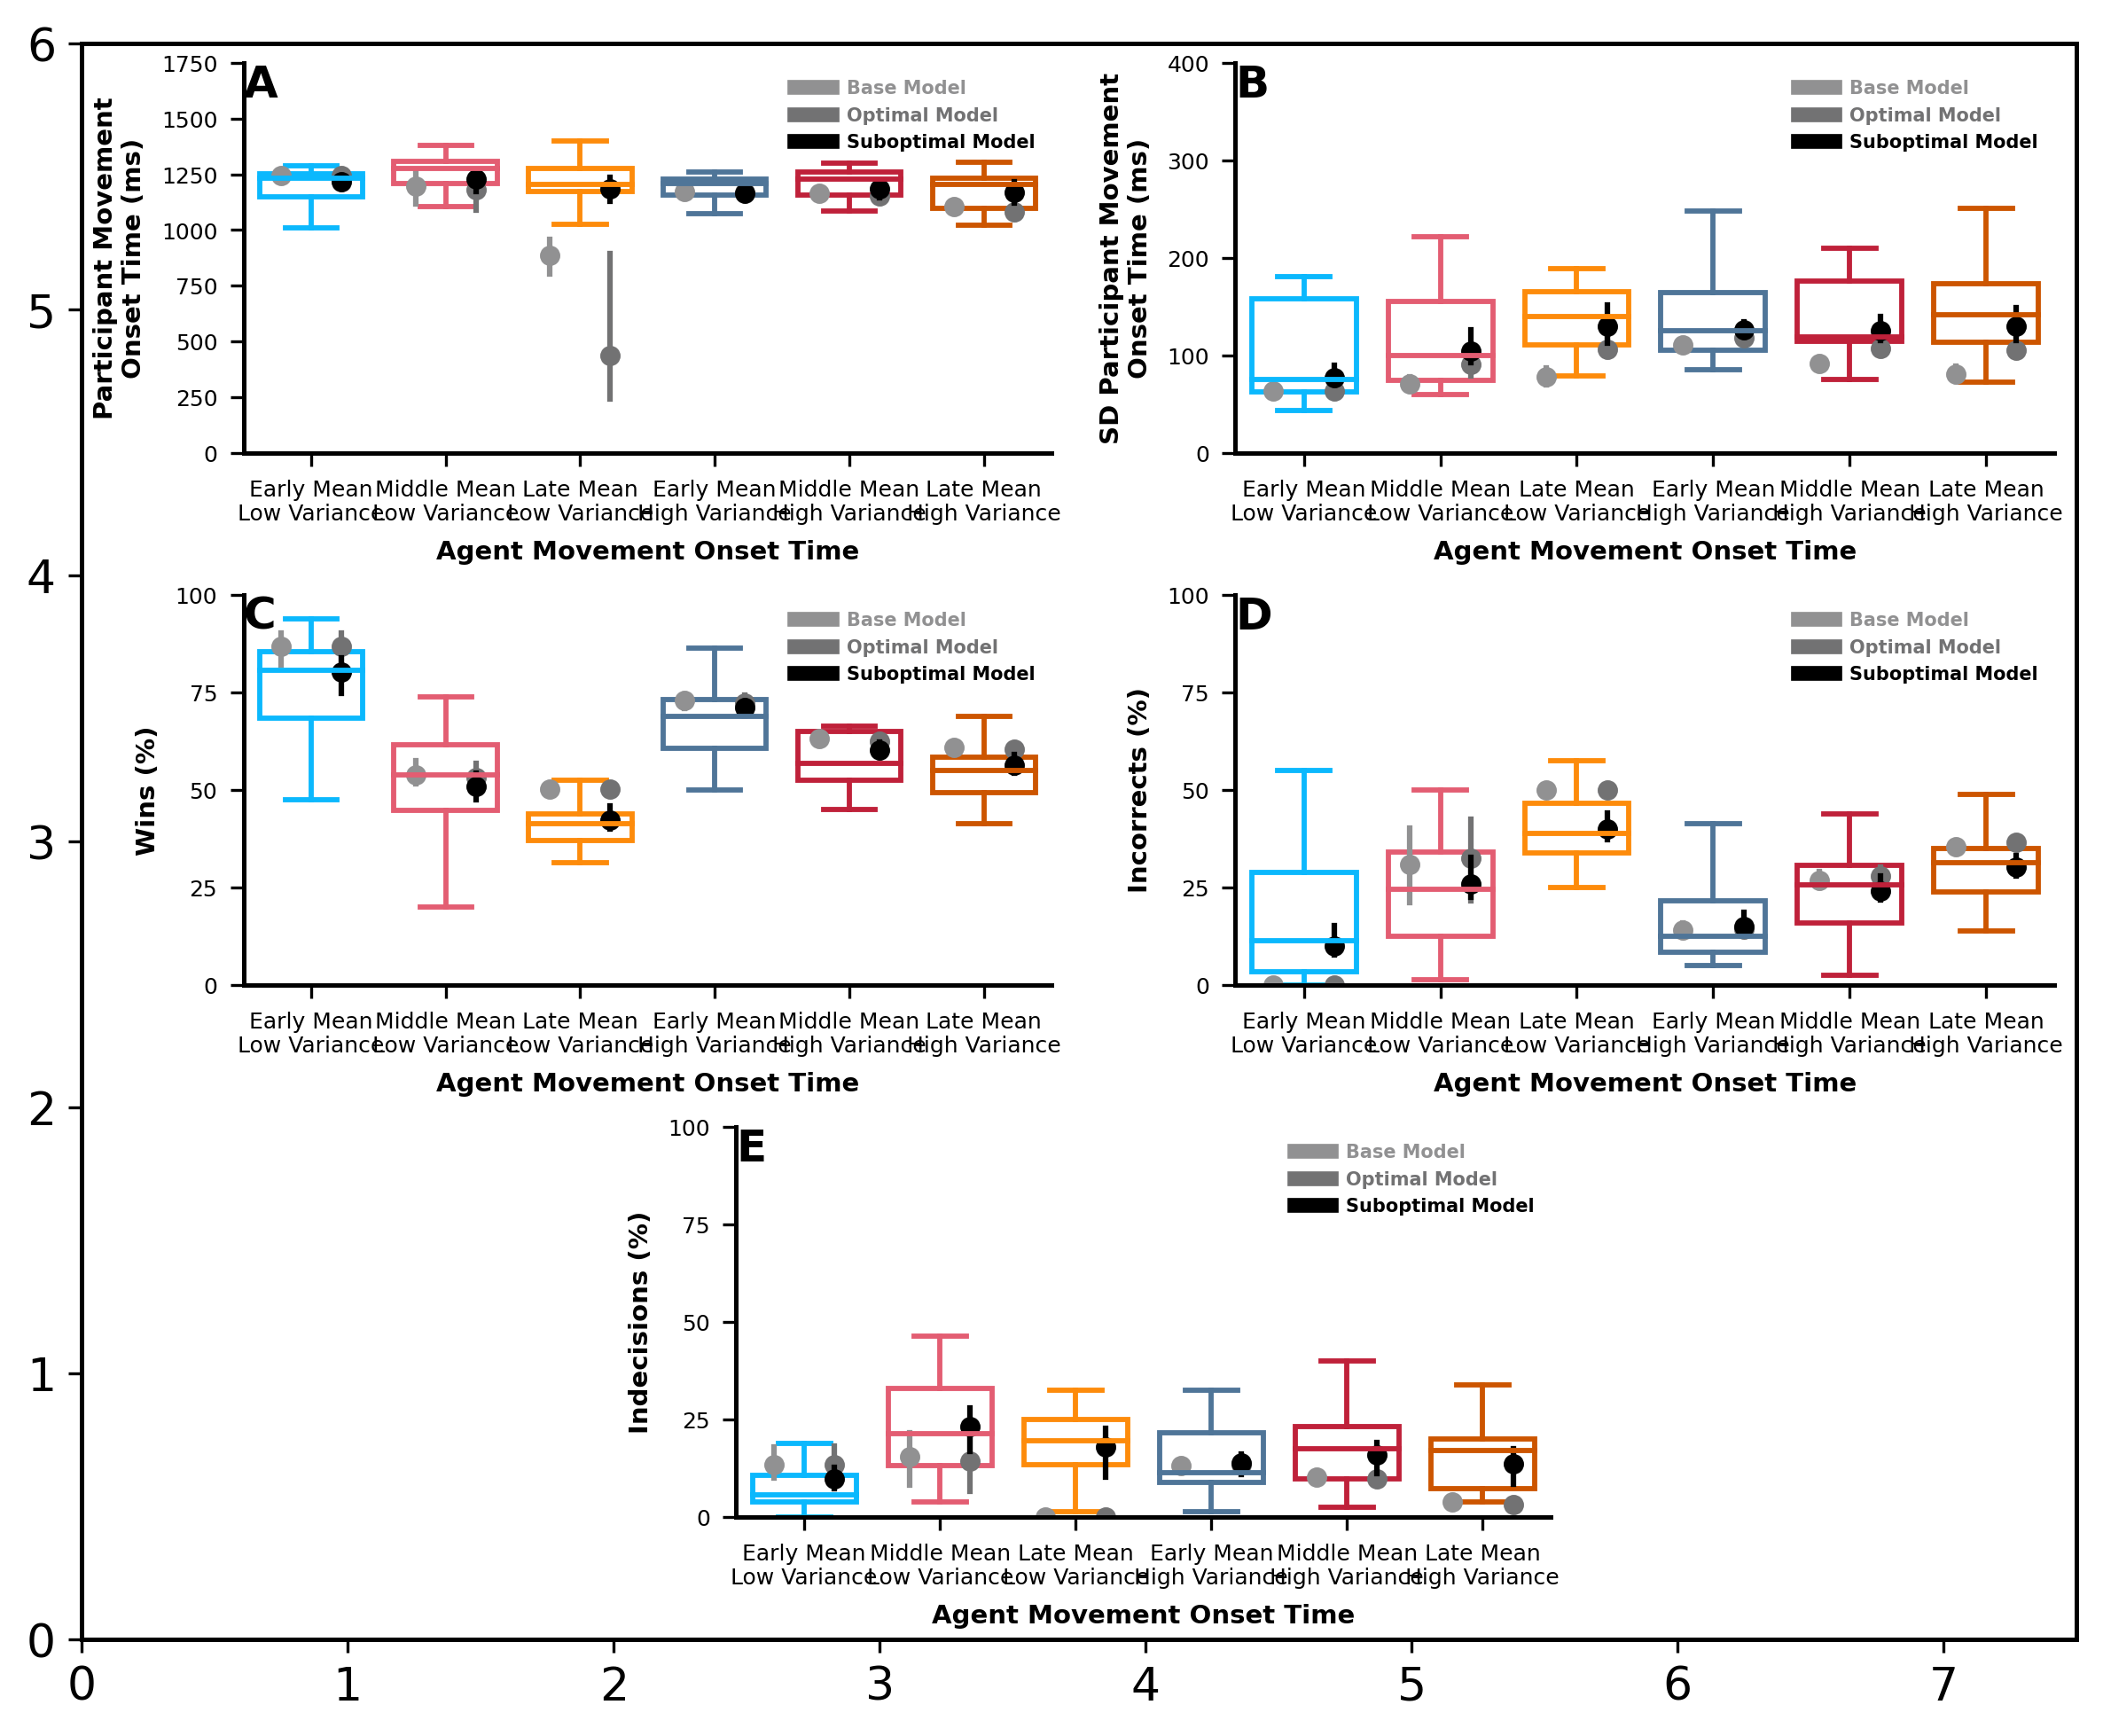

In [ ]:
save_path = Path(
    r"D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\figures"
)
w, h = 7.5, 6
bw = (
    0.35 * w
) / it.num_blocks  # box widths of all boxes combined takes up 30% of the width
mult_w, div_w = 0.053, 2.3
div_h = 1.75
xlocs = np.linspace(0, w / div_w, num=len(it.trial_block_titles))
legend_fontsize = 5
ticklabel_fontsize = 6
suptitle_fontsize = 6
label_fontsize = 7
markersize = 0.1*(w*h)

metrics = np.array(
    [
        participant_median_movement_onset_time,
        participant_sd_movement_onset_time,
        participant_perc_wins,
        participant_perc_incorrects,
        participant_perc_indecisions,
    ]
)[
    :, :, [0, 2, 4, 1, 3, 5]
]  # Rearranging axes to get the order I want
ylocs = (
    [np.arange(0, 1751, 250)] + [np.arange(0, 401, 100)] + [np.arange(0, 101, 25)] * 3
)
ylabels = [
    "Participant Movement\nOnset Time (ms)",
    "SD Participant Movement\nOnset Time (ms)",
    "Wins (%)",
    "Incorrects (%)",
    "Indecisions (%)",
]
ylims = [(0, 1750)] + [(0, 400)] + [(0, 100)] * 3

model_labels = ["Base Model", "Optimal Model", "Suboptimal Model"]
# save_names = ["exp1_results_only_optimal_model", 'exp1_results_both_models','exp1_results_statistics',]
suptitles = ["Model Results", "Model Results", "Participant Behaviour"]
legend_locs = (0.58, 0.86)
median_dicts = [base_medians, optimal_medians, suboptimal_medians]
interval_dicts = [base_intervals, optimal_intervals, suboptimal_intervals]

mosaic = "aabb;ccdd;.ee."
fig = pf.NewFigure(mosaic, dpi=300, figsize=(w, h),wspace=None, hspace=None)
axs = list(fig.axes.values())
model_colors = [wheel.grey, wheel.dark_grey, wheel.black]
# * Looping axes for each metric
for i, (ax, col_name) in enumerate(zip(axs, col_names)):
    # * Looping each experimental condition
    for j in range(len(xlocs)):
        dv.boxplot(
            ax,
            xlocs[j],
            metrics[i, :, j],
            color=constants.xticklabel_colors_means[j],
            data_color=constants.xticklabel_colors_means[j],
            box_lw=1.4
        )
        for k, (model_medians, model_intervals) in enumerate(
            zip(median_dicts, interval_dicts)
        ):
            if k == 0:
                shift = -bw / 3
            if k == 1:
                shift = +bw / 3
            pf.plot_boostrapped_model_results(
                ax,
                xlocs[j] + shift,
                y=model_medians[col_name][j],
                percentiles=model_intervals[col_name][:, j],
                horizontal_lw=0,
                markersize=markersize,
                color=model_colors[k],
            )

    # dv.jitter_array(ax=ax,x_positions=xlocs,data=metrics[i,:,:].T,
    #                 data_color = constants.xticklabel_colors_means,
    #                 data_edge_color = wheel.lighten_color(wheel.light_grey,1.2),
    #                 noise_scale=0.06, include_mean = False, circle_size=40)

    ax.set_ylim(ylims[i])
    ax.set_xlim(min(xlocs) - 0.75*bw, max(xlocs) + 0.75*bw)
    ax.set_xticks(xlocs, labels=constants.xticklabels, fontsize=ticklabel_fontsize)
    ax.set_yticks(ylocs[i], labels=ylocs[i], fontsize=ticklabel_fontsize)
    ax.set_xlabel(it.xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabels[i], fontsize=label_fontsize)
    dv.legend(ax, labels=model_labels, colors=model_colors,fontsize=legend_fontsize)
    # [ticklabel.set_color(color) for (color,ticklabel) in zip(constants.xticklabel_colors_means,ax.xaxis.get_ticklabels())]

fig.add_all_letters()
fig.fig.facecolor = 1
# fig.pad_fig(w_pad=-2,h_pad=0,w_space=-2,h_space=0.1)
for ax_label in ["a","b","c", "d"]:
    if ax_label in ["b","d"]:
        fig.adjust_position(fig.axes[ax_label], (-0.1, 0))
    fig.adjust_size(fig.axes[ax_label], (0.1, 0))
# plt.subplots_adjust(right=0.8)
# plt.subplot_tool()
plt.show()
# fig.savefig(SAVE_PATH / "test.png")

In [ ]:
model_results[0]['target_reach_times'][0]

array([1416.7006194 , 1335.70540753, 1318.83165984, 1325.97692469,
       1034.95466561, 1263.69189744])

{'Suboptimal_All': 'ab'}

Base 1432.5
Base 1072.0
Base 836.0
Base 1096.0
Base 1072.0
Base 1029.0
Optimal 1418.0
Optimal 1061.0
Optimal 383.0
Optimal 1089.0
Optimal 1058.0
Optimal 1008.0
Suboptimal_All 1071.0
Suboptimal_All 1082.0
Suboptimal_All 1081.0
Suboptimal_All 1072.0
Suboptimal_All 1075.0
Suboptimal_All 1066.0


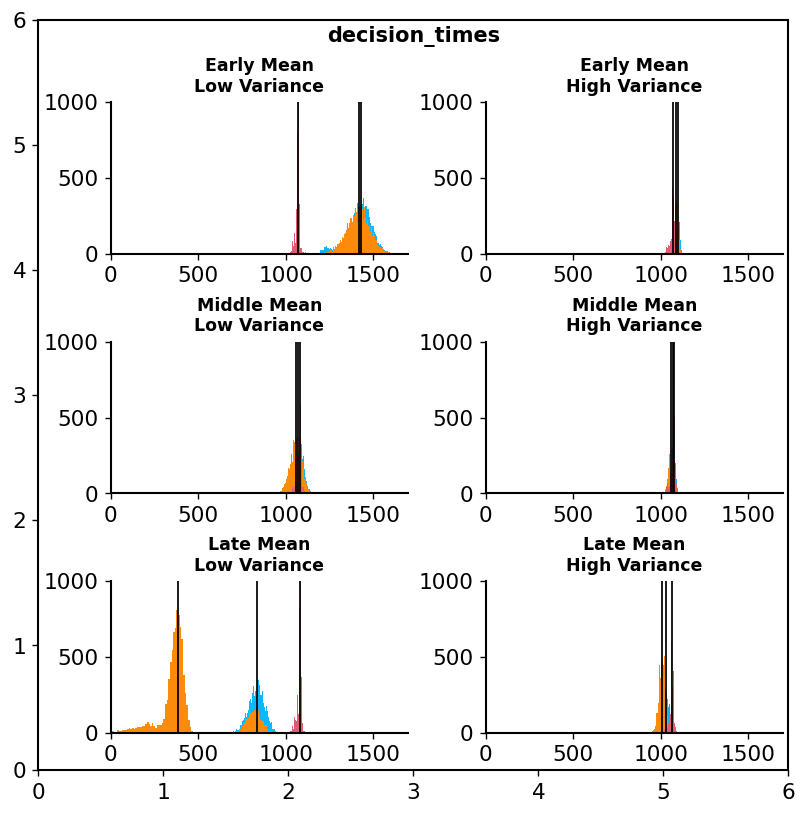

Base 1406.1250896804677
Base 1359.3510964258944
Base 1048.9150599799036
Base 1333.1735046679275
Base 1328.21001536014
Base 1266.5059114803616
Optimal 1406.1251484211148
Optimal 1343.2294429383276
Optimal 600.744622775555
Optimal 1329.1923393746001
Optimal 1315.7569365825232
Optimal 1245.4679698539355
Suboptimal_All 1377.0899675508056
Suboptimal_All 1390.9874220231895
Suboptimal_All 1348.6761581848946
Suboptimal_All 1327.4824227290383
Suboptimal_All 1348.7863384418201
Suboptimal_All 1334.294105562101


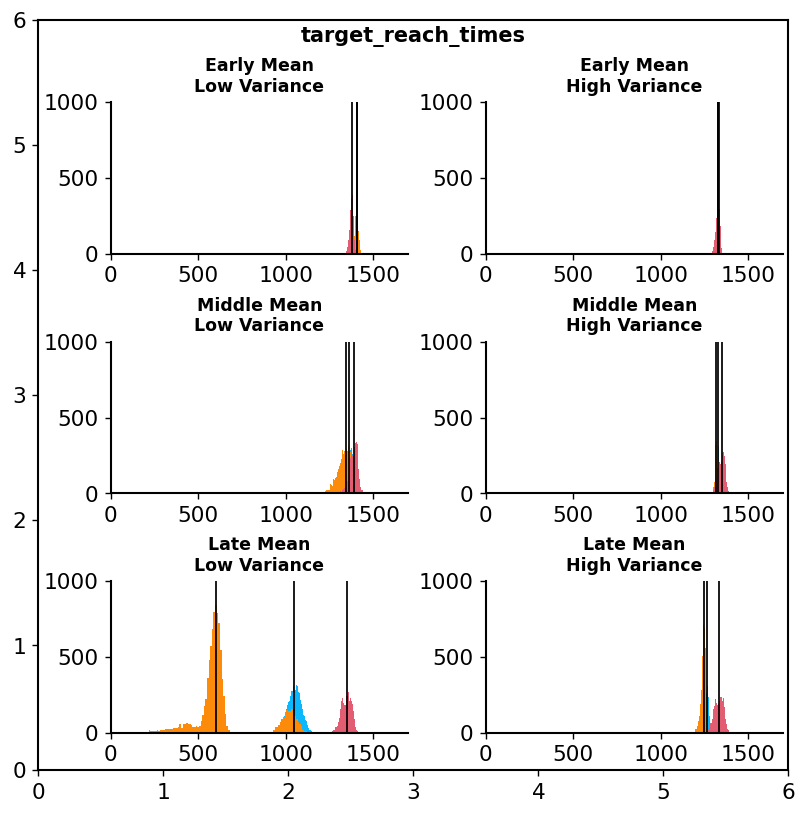

In [ ]:
parameter_columns = ["decision_times",
           "target_reach_times",
           "target_reach_times_sd",
           "median_movement_onset_time",
           "sd_movement_onset_time",
           "indecisions",
           "wins",
           "incorrects",
           ]
model_name_to_figure = {model_names[2]:'ab'}
xlims = {'timing_sd':(0,100),"guess_switch_delay":(0,100), "guess_switch_sd":(0,175)}
for i,col_name in enumerate(parameter_columns[:2]):
    fig = pf.NewFigure("ad;be;cf",figsize = (6,6),dpi=125)
    for df_inputs,model_name in zip(model_results,model_names):
        col = np.stack(df_inputs[col_name].to_numpy()).squeeze()
        if col.ndim>2:
            col = col[:,1,[0, 2, 4, 1, 3, 5]] # Get the expected decision times
        else:
            col = col[:,[0, 2, 4, 1, 3, 5]]
        for j,ax in enumerate(fig.alphabetic_axes.values()): # Looping through each condition
            # idx = model_name_to_figure[model_name][j]
            ax.hist(col[:,j],align='mid',bins=100)
            ax.axvline(np.nanmedian(col[:,j]), lw=1)
            print(model_name, np.nanmedian(col[:,j]))
            ax.set_title(constants.xticklabels[j],fontsize=10)
            fig.fig.suptitle(col_name, fontsize = 12)
            ax.set_xlim(0,1700)
            ax.set_ylim(0,1000)
            
            # fig.axes[idx].set_xlim(xlims[col_name])
                # ax.set_xlim(0,16)
                # fig.remove_figure_borders()
        
    plt.show()

{'a': <Axes: label='a', title={'center': 'Early Mean\nLow Variance'}>,
 'b': <Axes: label='b', title={'center': 'Late Mean\nLow Variance'}>,
 'c': <Axes: label='c', title={'center': 'Middle Mean\nHigh Variance'}>,
 'd': <Axes: label='d', title={'center': 'Middle Mean\nLow Variance'}>,
 'e': <Axes: label='e', title={'center': 'Early Mean\nHigh Variance'}>,
 'f': <Axes: label='f', title={'center': 'Late Mean\nHigh Variance'}>}

In [ ]:
np.stack(df_inputs[col_name].to_numpy()).squeeze().shape

(10000, 2, 6)

In [ ]:
fig.axes.values()

dict_values([<Axes: label='a'>, <Axes: label='b'>, <Axes: label='c'>, <Axes: label='d'>, <Axes: label='e'>, <Axes: label='f'>, <Axes: label='g'>, <Axes: label='h'>])